# ETAPA 1 - Análise Descritiva da Exposição de IA Generativa com ILO Index e PNADc
## ANÁLISE DOS DADOS 


**Dissertação:** Inteligência Artificial Generativa e o Mercado de Trabalho Brasileiro: Uma Análise de Exposição Ocupacional e seus Efeitos Distributivos.

**Aluno:** Manoel Brasil Orlandi

### Contextualização

A rápida difusão de modelos de IA generativa (LLMs, geradores de imagem/código) levanta questões centrais sobre seus impactos no mercado de trabalho. Para mensurar esse potencial de impacto, a  Organização Internacional do Trabalho (OIT) criou índice de exposição ocupacional à IA generativa, publicado como *Working Paper* 140 (WP140). O índice atribui scores de exposição a cada ocupação da classificação ISCO-08, com base na avaliação de suas tarefas constituintes por modelos de linguagem e validação humana.

Este notebook faz a análise e descrição pouplacional usando como base os dados `pnad_ilo_merged.csv` que junta os microdados da **PNAD Contínua** (Pesquisa Nacional por Amostra de Domicílios Contínua, IBGE, 3º trimestre de 2025) ao **índice de exposição à IA generativa da OIT* e foram preparados no notebook `etapa_1a_preparacao_dados_ilo_pnadc.ipynb`. 

### Objetivo da Análise

**Perfil da exposição**: Distribuição da população por quintil/decil de exposição; média ponderada de exposure_score por grupo.

**Desigualdade e renda**: Rendimento médio (e mediano) ponderado por quintil de exposição; razão renda Q5/Q1 de exposição.

**Gênero e raça**: % de mulheres e de negros por quintil de exposição; exposição média por sexo e raça	

**Formalidade**: % formal por quintil de exposição; exposição média no formal vs informal	

**Setor e ocupação**: Exposição média por setor_agregado e por grande_grupo; concentração em setores críticos IA.

**Região**: Exposição média por região; população em alta exposição por UF/região.

**Idade e instrução**: Exposição média por faixa etária e nível de instrução.

### Referências principais

- Gmyrek, P., Berg, J. & Cappelli, D. (2025). *Generative AI and Jobs: An updated global assessment of potential effects on job quantity and quality*. ILO Working Paper 140.
- IBGE. *Pesquisa Nacional por Amostra de Domicílios Contínua* (PNADc), 3º trimestre de 2025.

### 1. Configuração do ambiente
Definir caminhos, importar bibliotecas e configurar logs. 

In [2]:
# Instalar dependencias no kernel atual (executar apenas uma vez)
%pip install pandas numpy pyarrow openpyxl statsmodels scipy matplotlib seaborn --quiet


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Etapa 1b.1 - Analise de Dados - Configuracao do ambiente

import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import gaussian_kde, ks_2samp, linregress
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
import statsmodels.formula.api as smf
import statsmodels.api as sm

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', '{:.3f}'.format)

# ---------------------------------------------------------------------------
# Estilo visual
# ---------------------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 100,
})

# ---------------------------------------------------------------------------
# Caminhos
# ---------------------------------------------------------------------------
DATA_OUTPUT = Path("data/output")
DATA_INPUT  = Path("data/input")

# ---------------------------------------------------------------------------
# Parametros
# ---------------------------------------------------------------------------
SALARIO_MINIMO = 1518
PNAD_ANO       = 2025
PNAD_TRIMESTRE = 3

# ---------------------------------------------------------------------------
# Mapeamentos e constantes (replicados de settings.py)
# ---------------------------------------------------------------------------
REGIAO_MAP = {
    'RO': 'Norte', 'AC': 'Norte', 'AM': 'Norte', 'RR': 'Norte',
    'PA': 'Norte', 'AP': 'Norte', 'TO': 'Norte',
    'MA': 'Nordeste', 'PI': 'Nordeste', 'CE': 'Nordeste', 'RN': 'Nordeste',
    'PB': 'Nordeste', 'PE': 'Nordeste', 'AL': 'Nordeste', 'SE': 'Nordeste', 'BA': 'Nordeste',
    'MG': 'Sudeste', 'ES': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'SC': 'Sul', 'RS': 'Sul',
    'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste',
}

GRANDES_GRUPOS = {
    '1': 'Dirigentes e gerentes',
    '2': 'Profissionais das ciencias',
    '3': 'Tecnicos nivel medio',
    '4': 'Apoio administrativo',
    '5': 'Servicos e vendedores',
    '6': 'Agropecuaria qualificada',
    '7': 'Industria qualificada',
    '8': 'Operadores de maquinas',
    '9': 'Ocupacoes elementares',
}

GRADIENT_ORDER = [
    'Not Exposed', 'Minimal Exposure',
    'Exposed: Gradient 1', 'Exposed: Gradient 2',
    'Exposed: Gradient 3', 'Exposed: Gradient 4',
]

GRADIENT_COLORS = {
    'Not Exposed':          '#2ca02c',
    'Minimal Exposure':     '#98df8a',
    'Exposed: Gradient 1':  '#aec7e8',
    'Exposed: Gradient 2':  '#ffbb78',
    'Exposed: Gradient 3':  '#ff7f0e',
    'Exposed: Gradient 4':  '#d62728',
    'Sem classificacao':    '#d9d9d9',
}

GRADIENT_LABELS_PT = {
    'Not Exposed':          'Nao Exposto',
    'Minimal Exposure':     'Exposicao Minima',
    'Exposed: Gradient 1':  'Gradiente 1 (Aumento)',
    'Exposed: Gradient 2':  'Gradiente 2',
    'Exposed: Gradient 3':  'Gradiente 3',
    'Exposed: Gradient 4':  'Gradiente 4 (Automacao)',
}

HIGH_EXPOSURE_GRADIENTS = ['Exposed: Gradient 3', 'Exposed: Gradient 4']
QUINTIL_ORDER = ['Q1 (Baixa)', 'Q2', 'Q3', 'Q4', 'Q5 (Alta)']
DECIL_ORDER = [f'D{i}' for i in range(1, 11)]

NIVEL_INSTRUCAO_ORDER = [
    'Sem instrucao', 'Fundamental incompleto', 'Fundamental completo',
    'Medio incompleto', 'Medio completo', 'Superior incompleto', 'Superior completo',
]

SETORES_CRITICOS_IA = [
    'Informacao e Comunicacao', 'Financas e Seguros', 'Servicos Profissionais',
]

# ---------------------------------------------------------------------------
# Funcoes utilitarias - estatisticas ponderadas
# ---------------------------------------------------------------------------
def weighted_mean(values, weights):
    """Media ponderada (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    return np.average(values[mask], weights=weights[mask])

def weighted_std(values, weights):
    """Desvio-padrao ponderado (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    avg = np.average(values[mask], weights=weights[mask])
    variance = np.average((values[mask] - avg) ** 2, weights=weights[mask])
    return np.sqrt(variance)

def weighted_quantile(values, weights, quantile):
    """Quantil ponderado por pesos amostrais (ignora NaN)."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() == 0:
        return np.nan
    sorted_idx = np.argsort(values[mask])
    sorted_values = values[mask].iloc[sorted_idx]
    sorted_weights = weights[mask].iloc[sorted_idx]
    cumsum = np.cumsum(sorted_weights)
    cutoff = quantile * cumsum.iloc[-1]
    return sorted_values.iloc[np.searchsorted(cumsum, cutoff)]

def gini_coefficient(values, weights):
    """Coeficiente de Gini ponderado."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() < 2:
        return np.nan
    x = np.array(values[mask])
    w = np.array(weights[mask])
    sorted_idx = np.argsort(x)
    sorted_x = x[sorted_idx]
    sorted_w = w[sorted_idx]
    cumsum_w = np.cumsum(sorted_w)
    cumsum_wx = np.cumsum(sorted_w * sorted_x)
    total_w = cumsum_w[-1]
    total_wx = cumsum_wx[-1]
    B = np.sum(cumsum_wx[:-1] * sorted_w[1:]) / (total_w * total_wx)
    return 1 - 2 * B

def weighted_ci(values, weights, alpha=0.05):
    """Retorna (media, IC_inferior, IC_superior) usando DescrStatsW."""
    mask = ~(pd.isna(values) | pd.isna(weights))
    if mask.sum() < 2:
        return np.nan, np.nan, np.nan
    d = DescrStatsW(data=np.array(values[mask]), weights=np.array(weights[mask]))
    ci = d.tconfint_mean(alpha=alpha)
    return d.mean, ci[0], ci[1]

def weighted_ttest_2groups(vals_a, weights_a, vals_b, weights_b):
    """Teste t ponderado para duas amostras independentes. Retorna (t_stat, p_value)."""
    mask_a = ~(pd.isna(vals_a) | pd.isna(weights_a))
    mask_b = ~(pd.isna(vals_b) | pd.isna(weights_b))
    d_a = DescrStatsW(data=np.array(vals_a[mask_a]), weights=np.array(weights_a[mask_a]))
    d_b = DescrStatsW(data=np.array(vals_b[mask_b]), weights=np.array(weights_b[mask_b]))
    cm = CompareMeans(d_a, d_b)
    t_stat, p_value, df = cm.ttest_ind()
    return t_stat, p_value

def sig_stars(p):
    """Retorna estrelas de significancia."""
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return ''

# ---------------------------------------------------------------------------
# Carregar dados
# ---------------------------------------------------------------------------
df = pd.read_csv(DATA_OUTPUT / "pnad_ilo_merged.csv")

# Garantir tipos corretos
df['cod_ocupacao'] = df['cod_ocupacao'].astype(str).str.zfill(4)
df['quintil_exposure'] = pd.Categorical(df['quintil_exposure'], categories=QUINTIL_ORDER, ordered=True)
df['decil_exposure'] = pd.Categorical(df['decil_exposure'], categories=DECIL_ORDER, ordered=True)

# Subsets uteis
df_score = df[df['exposure_score'].notna()].copy()  # com score de exposicao
df_renda = df[(df['tem_renda'] == 1) & df['exposure_score'].notna()].copy()  # com renda + score

print("=" * 60)
print("CONFIGURACAO CARREGADA")
print("=" * 60)
print(f"  Observacoes totais:    {len(df):,}")
print(f"  Com score exposicao:   {len(df_score):,}")
print(f"  Com renda + score:     {len(df_renda):,}")
print(f"  Populacao total:       {df['peso'].sum()/1e6:.1f} milhoes")
print(f"  Periodo: {PNAD_ANO} Q{PNAD_TRIMESTRE}")

# Nota metodologica
print("\n" + "-" * 60)
print("NOTA METODOLOGICA sobre erros-padrao:")
print("Erros-padrao e ICs tratam a amostra como aleatoria simples")
print("reponderada por V1028. A PNADc usa desenho complexo com")
print("estratificacao e conglomeracao; SEs podem ser subestimados.")
print("-" * 60)

CONFIGURACAO CARREGADA
  Observacoes totais:    207,901
  Com score exposicao:   206,230
  Com renda + score:     202,471
  Populacao total:       97.8 milhoes
  Periodo: 2025 Q3

------------------------------------------------------------
NOTA METODOLOGICA sobre erros-padrao:
Erros-padrao e ICs tratam a amostra como aleatoria simples
reponderada por V1028. A PNADc usa desenho complexo com
estratificacao e conglomeracao; SEs podem ser subestimados.
------------------------------------------------------------


### 2. Perfil da exposicao
Distribuicao da populacao por quintil/decil de exposicao; media ponderada de exposure_score por grupo.

**Analises:**
- Histograma + KDE da distribuicao de exposicao com overlay de gradientes ILO
- Tabela-resumo por gradiente ILO com top 5 ocupacoes COD
- Geracao de `cod_ilo_merged.csv`
- Medidas de desigualdade: Gini, P90/P10, curva de Lorenz
- Comparacao com literatura internacional (com ICs)

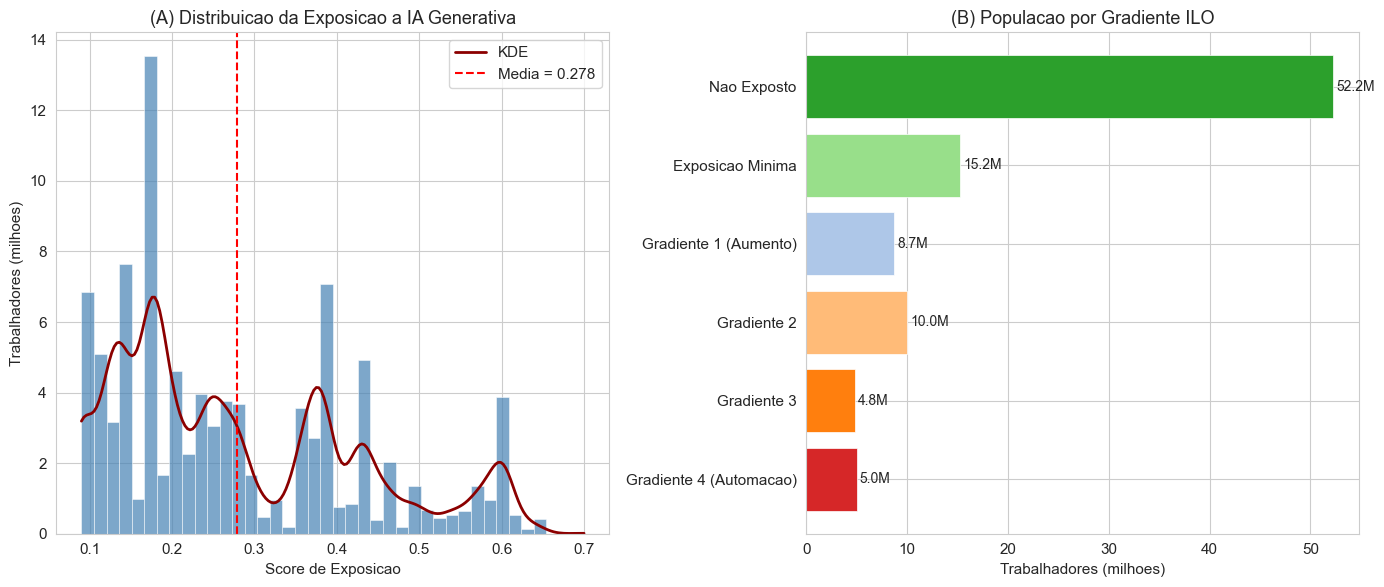

PERFIL DA EXPOSICAO POR GRADIENTE ILO

--- Nao Exposto (Not Exposed) ---
  Populacao: 52.2 milhoes (53.9%)
  Exposicao media: 0.169 [IC 95%: 0.169 - 0.169]
  Renda media: R$ 2,736
  % Formal: 36.7% | % Mulheres: 41.2%
  Top 5 ocupacoes (COD):
    9111 (Ocupacoes elementares): 3.87M trabalhadores, score=0.140
    9112 (Ocupacoes elementares): 2.69M trabalhadores, score=0.120
    7112 (Industria qualificada): 2.60M trabalhadores, score=0.090
    6111 (Agropecuaria qualificada): 2.00M trabalhadores, score=0.180
    9313 (Ocupacoes elementares): 1.67M trabalhadores, score=0.090

--- Exposicao Minima (Minimal Exposure) ---
  Populacao: 15.2 milhoes (15.7%)
  Exposicao media: 0.306 [IC 95%: 0.306 - 0.306]
  Renda media: R$ 4,449
  % Formal: 51.2% | % Mulheres: 37.7%
  Top 5 ocupacoes (COD):
    8332 (Operadores de maquinas): 1.97M trabalhadores, score=0.240
    3221 (Tecnicos nivel medio): 1.17M trabalhadores, score=0.220
    8321 (Operadores de maquinas): 1.16M trabalhadores, score=0.250
  

,grande_grupo,exposure_score,exposure_gradient,n_obs,pop_milhoes,renda_media,pct_formal
cod_ocupacao,,,,,,,
9111,Ocupações elementares,0.140,Not Exposed,9432,3.866,1303.005,24.289
4110,Apoio administrativo,0.600,Exposed: Gradient 4,7532,3.752,2823.199,65.708
5223,Serviços e vendedores,0.380,Exposed: Gradient 1,6825,3.541,2091.706,74.294
5221,Serviços e vendedores,0.430,Exposed: Gradient 2,6337,2.880,4071.596,0.000
9112,Ocupações elementares,0.120,Not Exposed,5947,2.688,1733.183,67.528



METRICAS DE DESIGUALDADE NA EXPOSICAO
  Media: 0.278 [IC 95%: 0.278 - 0.278]
  Mediana: 0.240
  Gini: 0.2947
  P90/P10: 4.17 (P90=0.500, P10=0.120)


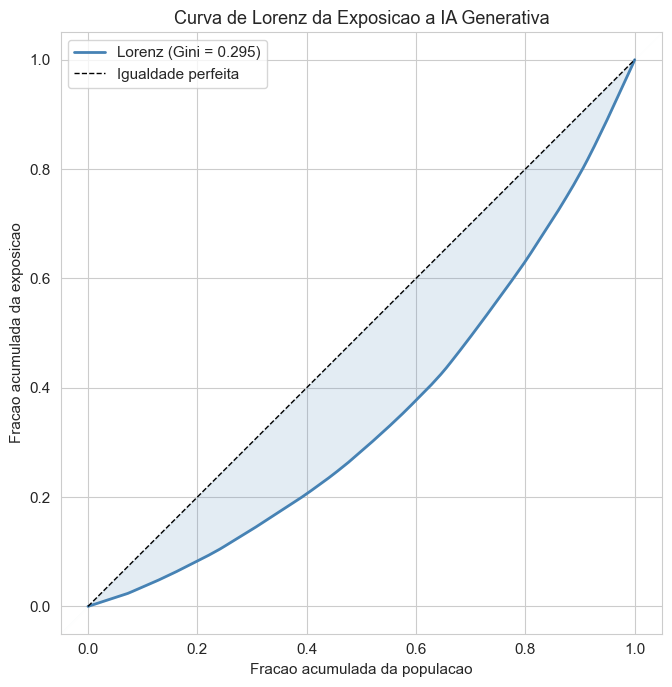


COMPARACAO COM LITERATURA INTERNACIONAL
Estudo                         Pais            Media        % Alta Exp. 
----------------------------------------------------------------------
Presente (ILO 2025)            Brasil          0.278        10.1%
Gmyrek et al. (2024)           Global          0.300        --          
Eloundou et al. (2023)         EUA             --           19.0%       

Nota: O Brasil apresenta exposicao media (0.278) ligeiramente
inferior a media global (0.30), consistente com a estrutura ocupacional
mais concentrada em servicos e ocupacoes manuais.


In [4]:
# Etapa 1b.2 - Analise de Dados - Perfil da exposicao

# ======================================================================
# 2.1 - Distribuicao da exposicao: histograma + KDE + gradientes
# ======================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Painel A: Histograma ponderado com KDE ---
ax = axes[0]
scores = df_score['exposure_score'].values
pesos = df_score['peso'].values
ax.hist(scores, bins=40, weights=pesos/1e6, color='steelblue', alpha=0.7,
        edgecolor='white', linewidth=0.5)

# KDE ponderado
kde = gaussian_kde(scores, weights=pesos/pesos.sum())
x_kde = np.linspace(scores.min(), scores.max(), 200)
# Escalar KDE para a mesma area do histograma
bin_width = (scores.max() - scores.min()) / 40
kde_scaled = kde(x_kde) * (pesos.sum()/1e6) * bin_width
ax.plot(x_kde, kde_scaled, color='darkred', linewidth=2, label='KDE')

media_exp = weighted_mean(df_score['exposure_score'], df_score['peso'])
ax.axvline(media_exp, color='red', linestyle='--', linewidth=1.5,
           label=f'Media = {media_exp:.3f}')
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Trabalhadores (milhoes)')
ax.set_title('(A) Distribuicao da Exposicao a IA Generativa')
ax.legend()

# --- Painel B: Populacao por gradiente ILO ---
ax = axes[1]
grad_data = []
for grad in GRADIENT_ORDER:
    sub = df_score[df_score['exposure_gradient'] == grad]
    if len(sub) > 0:
        pop = sub['peso'].sum() / 1e6
        grad_data.append({
            'Gradiente': GRADIENT_LABELS_PT.get(grad, grad),
            'Pop': pop,
            'Color': GRADIENT_COLORS.get(grad, '#999999'),
        })

grad_df = pd.DataFrame(grad_data)
bars = ax.barh(grad_df['Gradiente'], grad_df['Pop'], color=grad_df['Color'],
               edgecolor='white', linewidth=0.5)
for bar, pop in zip(bars, grad_df['Pop']):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
            f'{pop:.1f}M', va='center', fontsize=10)
ax.set_xlabel('Trabalhadores (milhoes)')
ax.set_title('(B) Populacao por Gradiente ILO')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# ======================================================================
# 2.2 - Tabela-resumo por gradiente ILO + top 5 ocupacoes
# ======================================================================
print("=" * 70)
print("PERFIL DA EXPOSICAO POR GRADIENTE ILO")
print("=" * 70)

total_pop = df_score['peso'].sum()
for grad in GRADIENT_ORDER:
    sub = df_score[df_score['exposure_gradient'] == grad]
    if len(sub) == 0:
        continue
    pop = sub['peso'].sum()
    pct = pop / total_pop * 100
    mean_exp, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    sub_renda = sub[sub['tem_renda'] == 1]
    mean_renda = weighted_mean(sub_renda['rendimento_habitual'], sub_renda['peso']) if len(sub_renda) > 0 else np.nan
    pct_formal = weighted_mean(sub['formal'], sub['peso']) * 100
    pct_mulher = weighted_mean((sub['sexo_texto'] == 'Mulher').astype(int), sub['peso']) * 100

    label = GRADIENT_LABELS_PT.get(grad, grad)
    print(f"\n--- {label} ({grad}) ---")
    print(f"  Populacao: {pop/1e6:.1f} milhoes ({pct:.1f}%)")
    print(f"  Exposicao media: {mean_exp:.3f} [IC 95%: {ci_lo:.3f} - {ci_hi:.3f}]")
    print(f"  Renda media: R$ {mean_renda:,.0f}" if not np.isnan(mean_renda) else "  Renda media: N/D")
    print(f"  % Formal: {pct_formal:.1f}% | % Mulheres: {pct_mulher:.1f}%")

    # Top 5 ocupacoes por populacao neste gradiente
    top5 = (sub.groupby('cod_ocupacao')
            .agg(pop_ocu=('peso', 'sum'), exp_mean=('exposure_score', 'mean'))
            .sort_values('pop_ocu', ascending=False)
            .head(5))
    print(f"  Top 5 ocupacoes (COD):")
    for cod, row in top5.iterrows():
        gg = GRANDES_GRUPOS.get(cod[0], '')
        print(f"    {cod} ({gg}): {row['pop_ocu']/1e6:.2f}M trabalhadores, score={row['exp_mean']:.3f}")

# ======================================================================
# 2.3 - Gerar cod_ilo_merged.csv
# ======================================================================
cod_summary = (df_score.groupby('cod_ocupacao')
    .agg(
        grande_grupo=('grande_grupo', 'first'),
        exposure_score=('exposure_score', 'mean'),
        exposure_gradient=('exposure_gradient', 'first'),
        n_obs=('peso', 'count'),
        pop_milhoes=('peso', lambda x: x.sum()/1e6),
        renda_media=('rendimento_habitual', lambda x: weighted_mean(x, df_score.loc[x.index, 'peso'])),
        pct_formal=('formal', lambda x: weighted_mean(x, df_score.loc[x.index, 'peso']) * 100),
    )
    .sort_values('pop_milhoes', ascending=False)
    .round(3)
)

cod_output = DATA_OUTPUT / "cod_ilo_merged.csv"
cod_summary.to_csv(cod_output)
print(f"\nTabela cod_ilo_merged.csv salva em: {cod_output}")
print(f"  {len(cod_summary)} ocupacoes | Top 5:")
display(cod_summary.head())

# ======================================================================
# 2.4 - Desigualdade: Gini, P90/P10, Curva de Lorenz
# ======================================================================
gini_exp = gini_coefficient(df_score['exposure_score'], df_score['peso'])
p90 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.90)
p10 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.10)
p50 = weighted_quantile(df_score['exposure_score'], df_score['peso'], 0.50)
ratio_p90_p10 = p90 / p10 if p10 > 0 else np.nan

# Media geral com IC
mean_geral, ci_lo_geral, ci_hi_geral = weighted_ci(df_score['exposure_score'], df_score['peso'])

print("\n" + "=" * 70)
print("METRICAS DE DESIGUALDADE NA EXPOSICAO")
print("=" * 70)
print(f"  Media: {mean_geral:.3f} [IC 95%: {ci_lo_geral:.3f} - {ci_hi_geral:.3f}]")
print(f"  Mediana: {p50:.3f}")
print(f"  Gini: {gini_exp:.4f}")
print(f"  P90/P10: {ratio_p90_p10:.2f} (P90={p90:.3f}, P10={p10:.3f})")

# Curva de Lorenz
vals = np.array(df_score['exposure_score'])
wgts = np.array(df_score['peso'])
sorted_idx = np.argsort(vals)
sorted_vals = vals[sorted_idx]
sorted_wgts = wgts[sorted_idx]
cum_pop = np.concatenate([[0], np.cumsum(sorted_wgts) / sorted_wgts.sum()])
cum_exp = np.concatenate([[0], np.cumsum(sorted_wgts * sorted_vals) / (sorted_wgts * sorted_vals).sum()])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(cum_pop, cum_exp, color='steelblue', linewidth=2,
        label=f'Lorenz (Gini = {gini_exp:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Igualdade perfeita')
ax.fill_between(cum_pop, cum_exp, cum_pop, alpha=0.15, color='steelblue')
ax.set_xlabel('Fracao acumulada da populacao')
ax.set_ylabel('Fracao acumulada da exposicao')
ax.set_title('Curva de Lorenz da Exposicao a IA Generativa')
ax.legend(loc='upper left')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# ======================================================================
# 2.5 - Comparacao com literatura internacional
# ======================================================================
n_alta = df_score[df_score['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
pct_alta = n_alta / df_score['peso'].sum() * 100

print("\n" + "=" * 70)
print("COMPARACAO COM LITERATURA INTERNACIONAL")
print("=" * 70)
print(f"{'Estudo':<30} {'Pais':<15} {'Media':<12} {'% Alta Exp.':<12}")
print("-" * 70)
print(f"{'Presente (ILO 2025)':<30} {'Brasil':<15} {mean_geral:.3f}        {pct_alta:.1f}%")
print(f"{'Gmyrek et al. (2024)':<30} {'Global':<15} {'0.300':<12} {'--':<12}")
print(f"{'Eloundou et al. (2023)':<30} {'EUA':<15} {'--':<12} {'19.0%':<12}")
print(f"\nNota: O Brasil apresenta exposicao media ({mean_geral:.3f}) ligeiramente")
print(f"inferior a media global (0.30), consistente com a estrutura ocupacional")
print(f"mais concentrada em servicos e ocupacoes manuais.")

### 3. Desigualdade e renda
Rendimento medio (e mediano) ponderado por quintil de exposicao; razao renda Q5/Q1 de exposicao.

**Analises:**
- Perfil de renda por quintil/decil com ICs 95%
- Grafico renda x decil com LOWESS + linear + barras de erro
- KDE de renda por quintil de exposicao
- Curva de concentracao da exposicao ordenada por renda
- Regressao quantilica: coeficiente de exposicao em tau = 0.10, 0.25, 0.50, 0.75, 0.90

PERFIL DE RENDA POR QUINTIL DE EXPOSICAO


,Renda Media (R$),IC 95% Inf,IC 95% Sup,Renda Mediana (R$),Exp. Media,% Formal,Pop. (milhoes)
Quintil,,,,,,,
Q1 (Baixa),2000.000,1999.100,2000.900,1600.000,0.100,37.400,20.500
Q2,2439.000,2437.600,2440.400,1900.000,0.200,30.000,17.700
Q3,3290.400,3288.600,3292.200,2500.000,0.200,46.300,21.300
Q4,4928.600,4925.400,4931.900,2900.000,0.400,52.300,17.200
Q5 (Alta),4468.600,4466.000,4471.200,2900.000,0.500,50.100,19.200



Razao renda Q5/Q1: 2.23x
  Q1 (Baixa exposicao): R$ 2,000
  Q5 (Alta exposicao):  R$ 4,469


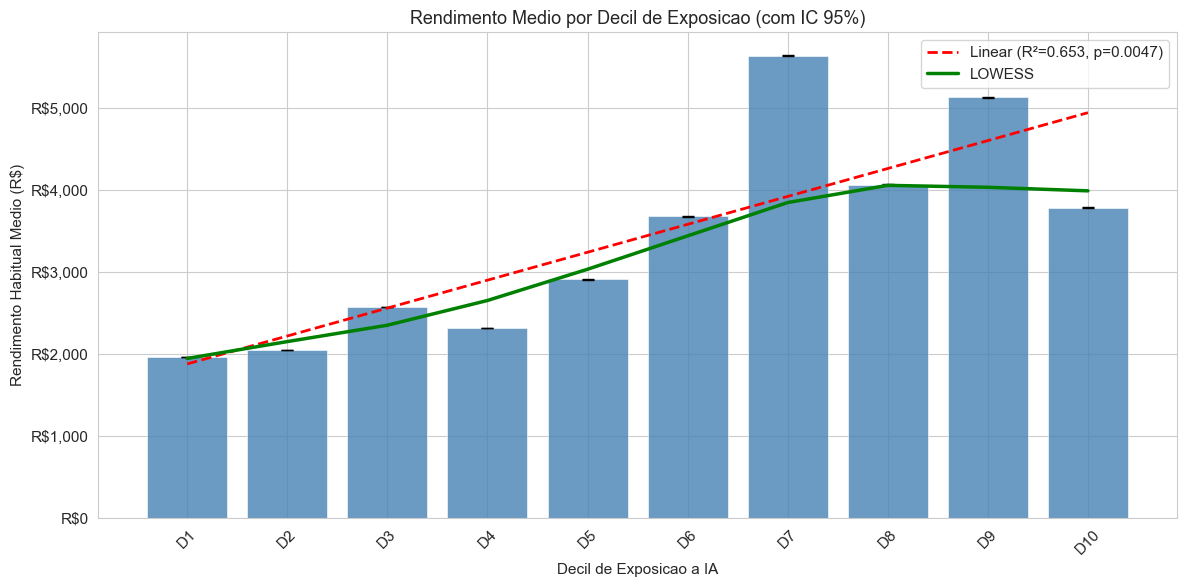


R² individual (WLS renda ~ exposicao): 0.0340
R² agregado (decis): 0.6526
Nota: R² agregado e artificialmente inflado por suavizar variancia individual.


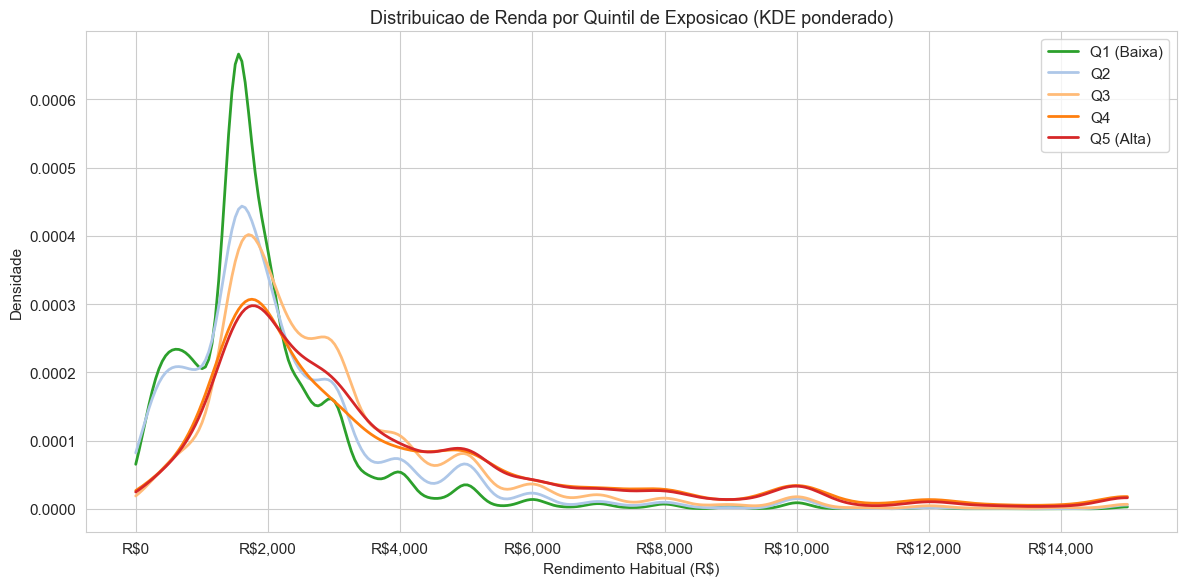


Indice de concentracao: 0.0810
  > 0: exposicao concentrada entre os mais ricos


/var/folders/9l/bxkb7j2s259_jlrwc_dnrklr0000gn/T/ipykernel_32166/2883019622.py:137: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  conc_area = np.trapz(cum_exp_c, cum_pop_c)


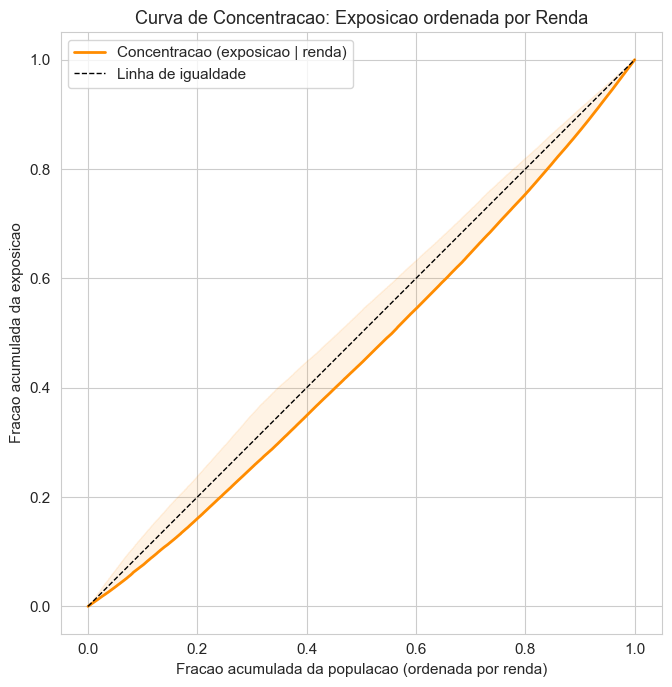


REGRESSAO QUANTILICA: log(renda) ~ exposicao + controles
  tau=0.10: coef=0.6177 (SE=0.0130) ***
  tau=0.25: coef=0.9900 (SE=0.0138) ***
  tau=0.50: coef=1.2090 (SE=0.0109) ***
  tau=0.75: coef=1.8282 (SE=0.0139) ***
  tau=0.90: coef=2.4992 (SE=0.0186) ***


,Coef. Exposicao,SE,IC 95% Inf,IC 95% Sup,p-valor,Sig.
Quantil,,,,,,
0.10,0.618,0.013,0.592,0.643,0.000,***
0.25,0.990,0.014,0.963,1.017,0.000,***
0.50,1.209,0.011,1.188,1.230,0.000,***
0.75,1.828,0.014,1.801,1.856,0.000,***
0.90,2.499,0.019,2.463,2.536,0.000,***


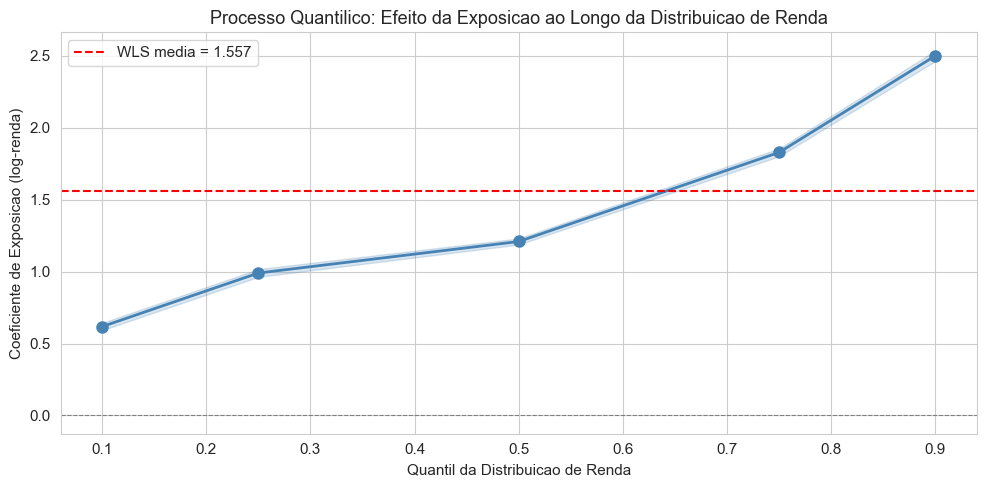


Interpretacao: Se o coeficiente cresce com o quantil, a exposicao
beneficia mais os trabalhadores de maior renda (complementaridade).
Se decresce, os de menor renda sao mais afetados (substituicao).


In [5]:
# Etapa 1b.3 - Analise de Dados - Desigualdade e renda

# ======================================================================
# 3.1 - Perfil de renda por quintil de exposicao com ICs
# ======================================================================
print("=" * 70)
print("PERFIL DE RENDA POR QUINTIL DE EXPOSICAO")
print("=" * 70)

rows_quintil = []
for q in QUINTIL_ORDER:
    sub = df_renda[df_renda['quintil_exposure'] == q]
    if len(sub) == 0:
        continue
    mean_r, ci_lo, ci_hi = weighted_ci(sub['rendimento_habitual'], sub['peso'])
    median_r = weighted_quantile(sub['rendimento_habitual'], sub['peso'], 0.50)
    rows_quintil.append({
        'Quintil': q,
        'Renda Media (R$)': mean_r,
        'IC 95% Inf': ci_lo,
        'IC 95% Sup': ci_hi,
        'Renda Mediana (R$)': median_r,
        'Exp. Media': weighted_mean(sub['exposure_score'], sub['peso']),
        '% Formal': weighted_mean(sub['formal'], sub['peso']) * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_quintil = pd.DataFrame(rows_quintil).set_index('Quintil')
display(tab_quintil.round(1))

# Razao Q5/Q1
renda_q5 = tab_quintil.loc['Q5 (Alta)', 'Renda Media (R$)']
renda_q1 = tab_quintil.loc['Q1 (Baixa)', 'Renda Media (R$)']
print(f"\nRazao renda Q5/Q1: {renda_q5/renda_q1:.2f}x")
print(f"  Q1 (Baixa exposicao): R$ {renda_q1:,.0f}")
print(f"  Q5 (Alta exposicao):  R$ {renda_q5:,.0f}")

# ======================================================================
# 3.2 - Grafico renda x decil com LOWESS + linear + barras de erro
# ======================================================================
decil_data = []
for d in DECIL_ORDER:
    sub = df_renda[df_renda['decil_exposure'] == d]
    if len(sub) == 0:
        continue
    mean_r, ci_lo, ci_hi = weighted_ci(sub['rendimento_habitual'], sub['peso'])
    decil_data.append({
        'Decil': d, 'Renda': mean_r, 'CI_lo': ci_lo, 'CI_hi': ci_hi,
        'Exp_media': weighted_mean(sub['exposure_score'], sub['peso']),
    })

dd = pd.DataFrame(decil_data)

fig, ax = plt.subplots(figsize=(12, 6))
x_pos = range(len(dd))
yerr = [dd['Renda'] - dd['CI_lo'], dd['CI_hi'] - dd['Renda']]
ax.bar(x_pos, dd['Renda'], yerr=yerr, capsize=4, color='steelblue', alpha=0.8,
       edgecolor='white', linewidth=0.5, error_kw={'linewidth': 1.5})

# Tendencia linear
slope, intercept, r_val, p_val, se = linregress(range(len(dd)), dd['Renda'])
ax.plot(x_pos, intercept + slope * np.array(x_pos), 'r--', linewidth=2,
        label=f'Linear (R²={r_val**2:.3f}, p={p_val:.4f})')

# LOWESS
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_fit = lowess(dd['Renda'].values, np.array(x_pos), frac=0.6)
    ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], 'g-', linewidth=2.5, label='LOWESS')
except ImportError:
    pass

ax.set_xticks(x_pos)
ax.set_xticklabels(dd['Decil'], rotation=45)
ax.set_ylabel('Rendimento Habitual Medio (R$)')
ax.set_xlabel('Decil de Exposicao a IA')
ax.set_title('Rendimento Medio por Decil de Exposicao (com IC 95%)')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
ax.legend()
plt.tight_layout()
plt.show()

# R² individual (WLS) para comparacao
model_ind = smf.wls('rendimento_habitual ~ exposure_score',
                     data=df_renda, weights=df_renda['peso']).fit()
print(f"\nR² individual (WLS renda ~ exposicao): {model_ind.rsquared:.4f}")
print(f"R² agregado (decis): {r_val**2:.4f}")
print("Nota: R² agregado e artificialmente inflado por suavizar variancia individual.")

# ======================================================================
# 3.3 - KDE de renda por quintil de exposicao
# ======================================================================
fig, ax = plt.subplots(figsize=(12, 6))
colors_q = ['#2ca02c', '#aec7e8', '#ffbb78', '#ff7f0e', '#d62728']
for i, q in enumerate(QUINTIL_ORDER):
    sub = df_renda[(df_renda['quintil_exposure'] == q) & (df_renda['rendimento_habitual'] <= 15000)]
    if len(sub) < 10:
        continue
    try:
        kde = gaussian_kde(sub['rendimento_habitual'].values,
                          weights=sub['peso'].values / sub['peso'].sum())
        x = np.linspace(0, 15000, 300)
        ax.plot(x, kde(x), color=colors_q[i], linewidth=2, label=q)
    except Exception:
        pass

ax.set_xlabel('Rendimento Habitual (R$)')
ax.set_ylabel('Densidade')
ax.set_title('Distribuicao de Renda por Quintil de Exposicao (KDE ponderado)')
ax.legend()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
plt.tight_layout()
plt.show()

# ======================================================================
# 3.4 - Curva de concentracao (exposicao ordenada por renda)
# ======================================================================
df_conc = df_renda.sort_values('rendimento_habitual').copy()
vals_c = np.array(df_conc['exposure_score'])
wgts_c = np.array(df_conc['peso'])
cum_pop_c = np.concatenate([[0], np.cumsum(wgts_c) / wgts_c.sum()])
cum_exp_c = np.concatenate([[0], np.cumsum(wgts_c * vals_c) / (wgts_c * vals_c).sum()])

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(cum_pop_c, cum_exp_c, color='darkorange', linewidth=2,
        label='Concentracao (exposicao | renda)')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Linha de igualdade')
ax.fill_between(cum_pop_c, cum_exp_c, np.linspace(0, 1, len(cum_pop_c)),
                alpha=0.1, color='darkorange')
ax.set_xlabel('Fracao acumulada da populacao (ordenada por renda)')
ax.set_ylabel('Fracao acumulada da exposicao')
ax.set_title('Curva de Concentracao: Exposicao ordenada por Renda')
ax.legend(loc='upper left')
ax.set_aspect('equal')

# Indice de concentracao
conc_area = np.trapz(cum_exp_c, cum_pop_c)
conc_index = 1 - 2 * conc_area
print(f"\nIndice de concentracao: {conc_index:.4f}")
if conc_index > 0:
    print("  > 0: exposicao concentrada entre os mais ricos")
elif conc_index < 0:
    print("  < 0: exposicao concentrada entre os mais pobres")

plt.tight_layout()
plt.show()

# ======================================================================
# 3.5 - Regressao quantilica
# ======================================================================
print("\n" + "=" * 70)
print("REGRESSAO QUANTILICA: log(renda) ~ exposicao + controles")
print("=" * 70)

df_qreg = df_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                      'raca_agregada', 'idade', 'formal']].dropna().copy()
df_qreg['log_renda'] = np.log(df_qreg['rendimento_habitual'].clip(lower=1))

quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]
qreg_results = []

for tau in quantiles:
    try:
        qr = smf.quantreg(
            'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + formal',
            data=df_qreg
        ).fit(q=tau, max_iter=1000)
        coef = qr.params['exposure_score']
        se = qr.bse['exposure_score']
        ci = qr.conf_int().loc['exposure_score']
        pval = qr.pvalues['exposure_score']
        qreg_results.append({
            'Quantil': f'{tau:.2f}',
            'Coef. Exposicao': coef,
            'SE': se,
            'IC 95% Inf': ci[0],
            'IC 95% Sup': ci[1],
            'p-valor': pval,
            'Sig.': sig_stars(pval),
        })
        print(f"  tau={tau:.2f}: coef={coef:.4f} (SE={se:.4f}) {sig_stars(pval)}")
    except Exception as e:
        print(f"  tau={tau:.2f}: ERRO - {e}")

if qreg_results:
    tab_qreg = pd.DataFrame(qreg_results).set_index('Quantil')
    display(tab_qreg.round(4))

    # Grafico do processo quantilico
    fig, ax = plt.subplots(figsize=(10, 5))
    coefs = [r['Coef. Exposicao'] for r in qreg_results]
    ci_lo = [r['IC 95% Inf'] for r in qreg_results]
    ci_hi = [r['IC 95% Sup'] for r in qreg_results]
    ax.plot(quantiles, coefs, 'o-', color='steelblue', linewidth=2, markersize=8)
    ax.fill_between(quantiles, ci_lo, ci_hi, alpha=0.2, color='steelblue')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # Adicionar coeficiente OLS como referencia
    ols_model = smf.wls(
        'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + formal',
        data=df_qreg, weights=df_renda.loc[df_qreg.index, 'peso']
    ).fit()
    ax.axhline(ols_model.params['exposure_score'], color='red', linestyle='--',
               linewidth=1.5, label=f'WLS media = {ols_model.params["exposure_score"]:.3f}')

    ax.set_xlabel('Quantil da Distribuicao de Renda')
    ax.set_ylabel('Coeficiente de Exposicao (log-renda)')
    ax.set_title('Processo Quantilico: Efeito da Exposicao ao Longo da Distribuicao de Renda')
    ax.legend()
    plt.tight_layout()
    plt.show()
    print("\nInterpretacao: Se o coeficiente cresce com o quantil, a exposicao")
    print("beneficia mais os trabalhadores de maior renda (complementaridade).")
    print("Se decresce, os de menor renda sao mais afetados (substituicao).")

### 4. Genero e raca
% de mulheres e de negros por quintil de exposicao; exposicao media por sexo e raca.

**Analises:**
- Exposicao por sexo e raca com ICs e testes t ponderados
- KDE comparativo: homens vs mulheres, brancos vs negros
- Exposicao por sexo x raca x quintil
- Decomposicao Oaxaca-Blinder do gap de genero
- Decomposicao Oaxaca-Blinder do gap racial

EXPOSICAO POR GENERO E RACA

--- Por Sexo ---
  Homem: 0.259 [IC: 0.259 - 0.259] | Pop: 54.3M
  Mulher: 0.303 [IC: 0.303 - 0.303] | Pop: 42.7M
  Gap (M-H): +0.044 | t=-1473.74, p=0.0000 ***

--- Por Raca ---
  Branca: 0.305 [IC: 0.305 - 0.305] | Pop: 41.9M
  Negra: 0.257 [IC: 0.257 - 0.257] | Pop: 54.0M
  Outras: 0.301 [IC: 0.301 - 0.302] | Pop: 1.0M
  Gap (Branca-Negra): +0.048 | t=1601.17, p=0.0000 ***


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Pop. (milhoes)
Grupo,,,,,
Homem,0.259,0.259,0.259,6.688,54.292
Mulher,0.303,0.303,0.303,14.397,42.674
Branca,0.305,0.305,0.305,12.403,41.881
Negra,0.257,0.257,0.257,8.255,54.046
Outras,0.301,0.301,0.302,11.432,1.039


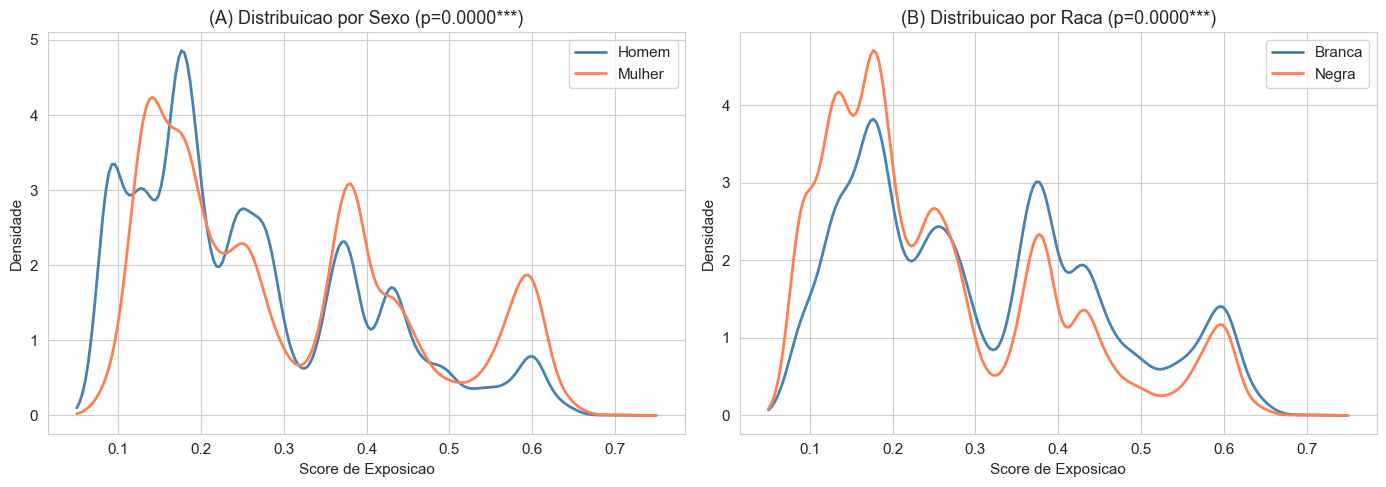

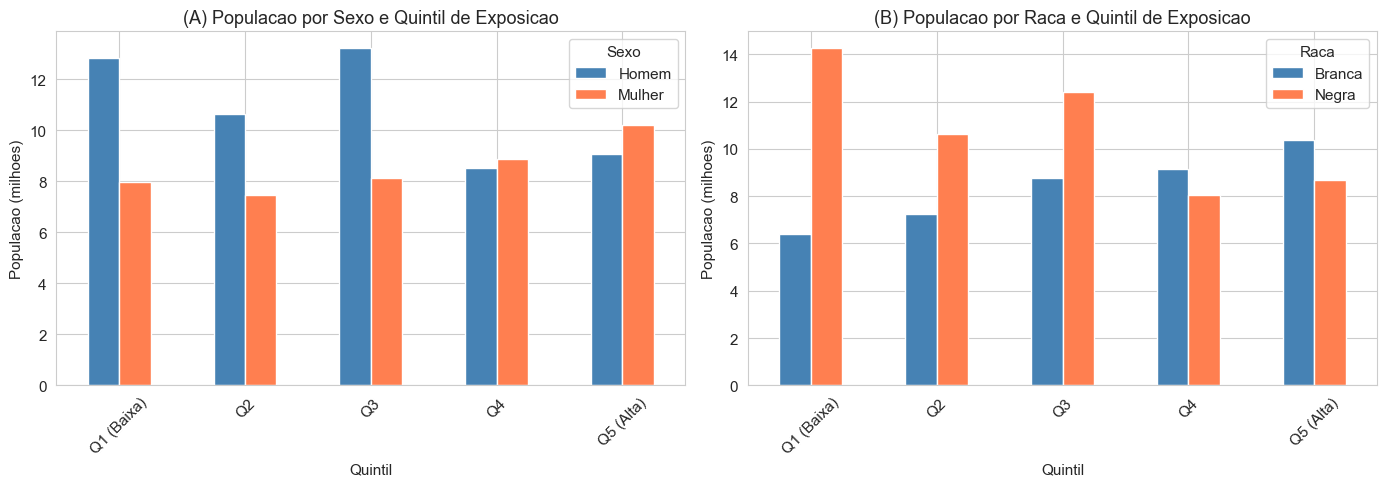


DECOMPOSICAO OAXACA-BLINDER DO GAP DE GENERO NA EXPOSICAO

  Exposicao media homens:   0.2589
  Exposicao media mulheres: 0.3028
  Gap total (M - H):        +0.0439
  Explicado (caracteristicas): +0.0542 (123.3%)
  Nao explicado (coeficientes): -0.0103 (-23.3%)

  Interpretacao: 123% do gap de genero e explicado por
  diferencas em escolaridade, ocupacao, regiao e formalidade.
  Os 23% restantes refletem segregacao ocupacional
  e diferente valoracao das mesmas caracteristicas.

DECOMPOSICAO OAXACA-BLINDER DO GAP RACIAL NA EXPOSICAO

  Exposicao media brancos: 0.3050
  Exposicao media negros:  0.2571
  Gap total (B - N):       +0.0479
  Explicado (caracteristicas): +0.0355 (74.1%)
  Nao explicado (coeficientes): +0.0124 (25.9%)

  Interpretacao: Trabalhadores brancos tem maior exposicao a IA
  (+0.048), refletindo concentracao em ocupacoes
  de maior qualificacao e setores mais tecnologicos.


In [6]:
# Etapa 1b.4 - Analise de Dados - Genero e raca

# ======================================================================
# 4.1 - Exposicao por sexo e raca com ICs e testes t
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR GENERO E RACA")
print("=" * 70)

# --- Por sexo ---
print("\n--- Por Sexo ---")
rows_sexo = []
for sexo in ['Homem', 'Mulher']:
    sub = df_score[df_score['sexo_texto'] == sexo]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    rows_sexo.append({
        'Grupo': sexo,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {sexo}: {mean_e:.3f} [IC: {ci_lo:.3f} - {ci_hi:.3f}] | Pop: {sub['peso'].sum()/1e6:.1f}M")

# Teste t genero
sub_h = df_score[df_score['sexo_texto'] == 'Homem']
sub_m = df_score[df_score['sexo_texto'] == 'Mulher']
t_sexo, p_sexo = weighted_ttest_2groups(
    sub_h['exposure_score'], sub_h['peso'],
    sub_m['exposure_score'], sub_m['peso']
)
gap_sexo = rows_sexo[1]['Exp. Media'] - rows_sexo[0]['Exp. Media']
print(f"  Gap (M-H): {gap_sexo:+.3f} | t={t_sexo:.2f}, p={p_sexo:.4f} {sig_stars(p_sexo)}")

# --- Por raca ---
print("\n--- Por Raca ---")
rows_raca = []
for raca in ['Branca', 'Negra', 'Outras']:
    sub = df_score[df_score['raca_agregada'] == raca]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    rows_raca.append({
        'Grupo': raca,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {raca}: {mean_e:.3f} [IC: {ci_lo:.3f} - {ci_hi:.3f}] | Pop: {sub['peso'].sum()/1e6:.1f}M")

# Teste t raca (Branca vs Negra)
sub_br = df_score[df_score['raca_agregada'] == 'Branca']
sub_ne = df_score[df_score['raca_agregada'] == 'Negra']
t_raca, p_raca = weighted_ttest_2groups(
    sub_br['exposure_score'], sub_br['peso'],
    sub_ne['exposure_score'], sub_ne['peso']
)
gap_raca = rows_raca[0]['Exp. Media'] - rows_raca[1]['Exp. Media']
print(f"  Gap (Branca-Negra): {gap_raca:+.3f} | t={t_raca:.2f}, p={p_raca:.4f} {sig_stars(p_raca)}")

# Tabela consolidada
tab_genero_raca = pd.DataFrame(rows_sexo + rows_raca).set_index('Grupo')
display(tab_genero_raca.round(3))

# ======================================================================
# 4.2 - KDE comparativo por sexo e raca
# ======================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Painel A: Sexo
ax = axes[0]
for sexo, cor in [('Homem', 'steelblue'), ('Mulher', 'coral')]:
    sub = df_score[df_score['sexo_texto'] == sexo]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=sexo)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'(A) Distribuicao por Sexo (p={p_sexo:.4f}{sig_stars(p_sexo)})')
ax.legend()

# Painel B: Raca
ax = axes[1]
for raca, cor in [('Branca', 'steelblue'), ('Negra', 'coral')]:
    sub = df_score[df_score['raca_agregada'] == raca]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=raca)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'(B) Distribuicao por Raca (p={p_raca:.4f}{sig_stars(p_raca)})')
ax.legend()

plt.tight_layout()
plt.show()

# ======================================================================
# 4.3 - Exposicao por sexo x quintil
# ======================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Painel A: Sexo x Quintil
ax = axes[0]
data_sq = []
for q in QUINTIL_ORDER:
    for sexo in ['Homem', 'Mulher']:
        sub = df_score[(df_score['quintil_exposure'] == q) & (df_score['sexo_texto'] == sexo)]
        if len(sub) > 0:
            data_sq.append({'Quintil': q, 'Sexo': sexo, 'Pop': sub['peso'].sum() / 1e6})

df_sq = pd.DataFrame(data_sq)
df_pivot = df_sq.pivot(index='Quintil', columns='Sexo', values='Pop')
df_pivot.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='white')
ax.set_ylabel('Populacao (milhoes)')
ax.set_title('(A) Populacao por Sexo e Quintil de Exposicao')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Sexo')

# Painel B: Raca x Quintil
ax = axes[1]
data_rq = []
for q in QUINTIL_ORDER:
    for raca in ['Branca', 'Negra']:
        sub = df_score[(df_score['quintil_exposure'] == q) & (df_score['raca_agregada'] == raca)]
        if len(sub) > 0:
            data_rq.append({'Quintil': q, 'Raca': raca, 'Pop': sub['peso'].sum() / 1e6})

df_rq = pd.DataFrame(data_rq)
df_pivot_r = df_rq.pivot(index='Quintil', columns='Raca', values='Pop')
df_pivot_r.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='white')
ax.set_ylabel('Populacao (milhoes)')
ax.set_title('(B) Populacao por Raca e Quintil de Exposicao')
ax.tick_params(axis='x', rotation=45)
ax.legend(title='Raca')

plt.tight_layout()
plt.show()

# ======================================================================
# 4.4 - Decomposicao Oaxaca-Blinder do gap de genero
# ======================================================================
print("\n" + "=" * 70)
print("DECOMPOSICAO OAXACA-BLINDER DO GAP DE GENERO NA EXPOSICAO")
print("=" * 70)

# Preparar dados para decomposicao
df_ob = df_score[['exposure_score', 'sexo_texto', 'raca_agregada', 'idade',
                    'nivel_instrucao', 'grande_grupo', 'regiao', 'formal', 'peso']].dropna().copy()

# Criar dummies manualmente para controle total
formula_ob = 'exposure_score ~ C(raca_agregada) + idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + formal'

df_h = df_ob[df_ob['sexo_texto'] == 'Homem']
df_m = df_ob[df_ob['sexo_texto'] == 'Mulher']

reg_h = smf.wls(formula_ob, data=df_h, weights=df_h['peso']).fit()
reg_m = smf.wls(formula_ob, data=df_m, weights=df_m['peso']).fit()

# Media das variaveis explicativas
import patsy
y_h, X_h = patsy.dmatrices(formula_ob, data=df_h, return_type='dataframe')
y_m, X_m = patsy.dmatrices(formula_ob, data=df_m, return_type='dataframe')

# Medias ponderadas das Xs
mean_X_h = np.average(X_h.values, axis=0, weights=df_h['peso'].values)
mean_X_m = np.average(X_m.values, axis=0, weights=df_m['peso'].values)

# Medias das Ys
mean_y_h = weighted_mean(df_h['exposure_score'], df_h['peso'])
mean_y_m = weighted_mean(df_m['exposure_score'], df_m['peso'])

# Decomposicao (referencia: coeficientes dos homens)
gap_total = mean_y_m - mean_y_h
explicado = (mean_X_m - mean_X_h) @ reg_h.params.values
nao_explicado = gap_total - explicado

print(f"\n  Exposicao media homens:   {mean_y_h:.4f}")
print(f"  Exposicao media mulheres: {mean_y_m:.4f}")
print(f"  Gap total (M - H):        {gap_total:+.4f}")
print(f"  Explicado (caracteristicas): {explicado:+.4f} ({explicado/gap_total*100:.1f}%)")
print(f"  Nao explicado (coeficientes): {nao_explicado:+.4f} ({nao_explicado/gap_total*100:.1f}%)")
print(f"\n  Interpretacao: {abs(explicado/gap_total*100):.0f}% do gap de genero e explicado por")
print(f"  diferencas em escolaridade, ocupacao, regiao e formalidade.")
print(f"  Os {abs(nao_explicado/gap_total*100):.0f}% restantes refletem segregacao ocupacional")
print(f"  e diferente valoracao das mesmas caracteristicas.")

# ======================================================================
# 4.5 - Decomposicao Oaxaca-Blinder do gap racial
# ======================================================================
print("\n" + "=" * 70)
print("DECOMPOSICAO OAXACA-BLINDER DO GAP RACIAL NA EXPOSICAO")
print("=" * 70)

formula_ob_raca = 'exposure_score ~ C(sexo_texto) + idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + formal'

df_br = df_ob[df_ob['raca_agregada'] == 'Branca']
df_ne = df_ob[df_ob['raca_agregada'] == 'Negra']

reg_br = smf.wls(formula_ob_raca, data=df_br, weights=df_br['peso']).fit()
reg_ne = smf.wls(formula_ob_raca, data=df_ne, weights=df_ne['peso']).fit()

y_br, X_br = patsy.dmatrices(formula_ob_raca, data=df_br, return_type='dataframe')
y_ne, X_ne = patsy.dmatrices(formula_ob_raca, data=df_ne, return_type='dataframe')

mean_X_br = np.average(X_br.values, axis=0, weights=df_br['peso'].values)
mean_X_ne = np.average(X_ne.values, axis=0, weights=df_ne['peso'].values)

mean_y_br = weighted_mean(df_br['exposure_score'], df_br['peso'])
mean_y_ne = weighted_mean(df_ne['exposure_score'], df_ne['peso'])

gap_raca_total = mean_y_br - mean_y_ne
explicado_raca = (mean_X_br - mean_X_ne) @ reg_ne.params.values
nao_explicado_raca = gap_raca_total - explicado_raca

print(f"\n  Exposicao media brancos: {mean_y_br:.4f}")
print(f"  Exposicao media negros:  {mean_y_ne:.4f}")
print(f"  Gap total (B - N):       {gap_raca_total:+.4f}")
print(f"  Explicado (caracteristicas): {explicado_raca:+.4f} ({explicado_raca/gap_raca_total*100:.1f}%)")
print(f"  Nao explicado (coeficientes): {nao_explicado_raca:+.4f} ({nao_explicado_raca/gap_raca_total*100:.1f}%)")
print(f"\n  Interpretacao: Trabalhadores brancos tem maior exposicao a IA")
print(f"  ({gap_raca_total:+.3f}), refletindo concentracao em ocupacoes")
print(f"  de maior qualificacao e setores mais tecnologicos.")

### 5. Formalidade
% formal por quintil de exposicao; exposicao media no formal vs informal.

**Analises:**
- Exposicao por formalidade com ICs e teste t ponderado
- Investigacao do "paradoxo da formalidade": cross-tab quintil x formalidade x renda + regressao com interacao
- KDE: formal vs informal

EXPOSICAO: FORMAL vs INFORMAL
  Formal: Exp=0.305 [IC: 0.305-0.305] | Renda=R$3,216 | Pop=41.4M
  Informal: Exp=0.258 [IC: 0.258-0.259] | Renda=R$3,519 | Pop=55.5M
  Gap (F-I): +0.046 | t=1549.24, p=0.0000 ***


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Renda Media (R$),Pop. (milhoes)
Tipo,,,,,,
Formal,0.305,0.305,0.305,14.804,3216.103,41.442
Informal,0.258,0.258,0.259,6.555,3518.691,55.525


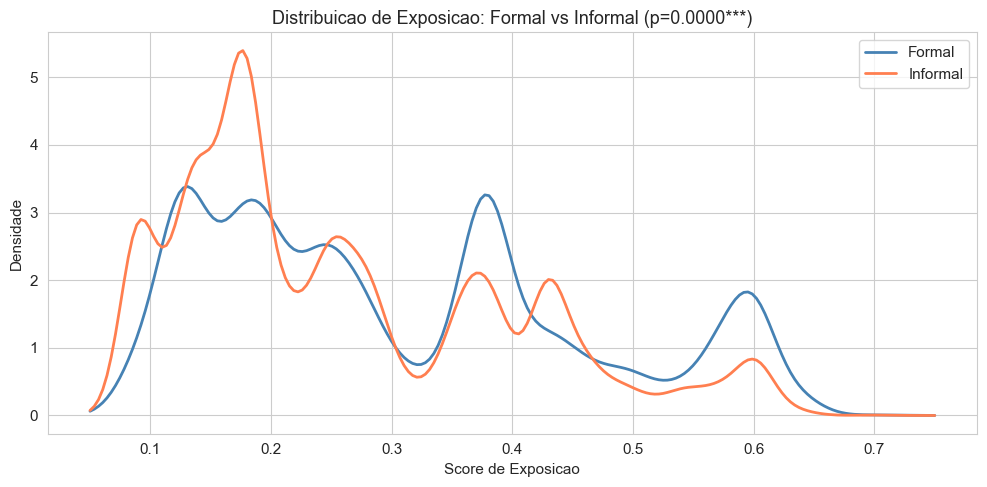


INVESTIGACAO: RENDA POR QUINTIL DE EXPOSICAO E FORMALIDADE


Tipo,Formal,Informal
Quintil,,
Q1 (Baixa),2135.000,1919.000
Q2,2545.000,2394.000
Q3,2972.000,3565.000
Q4,3898.000,6058.000
Q5 (Alta),4058.000,4881.000


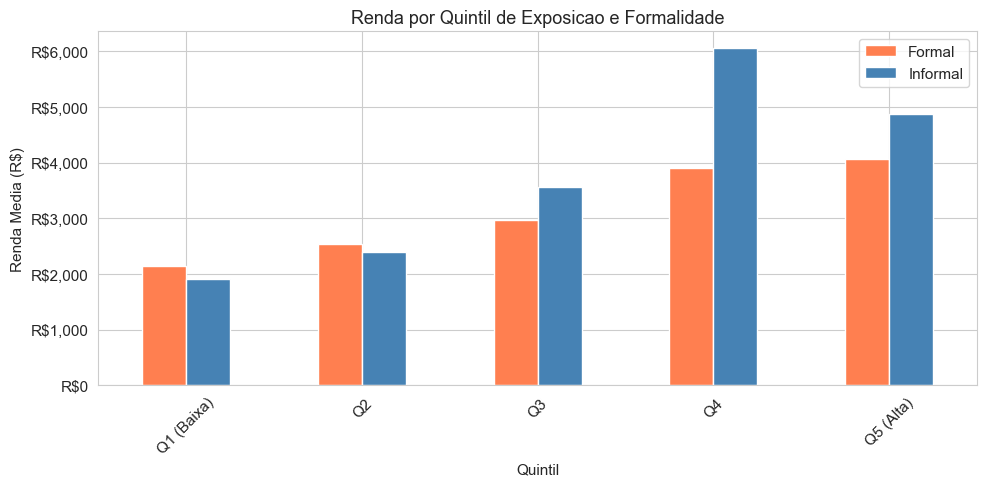


--- Regressao: log(renda) ~ exposicao * formalidade + controles ---

  exposure_score:         +2.1301 (p=0.0000***)
  formal:                 +0.4471 (p=0.0000***)
  exposure_score:formal:  -1.2137 (p=0.0000***)
  R²: 0.2485 | N: 202,471

  Interpretacao: Se a interacao exposicao:formal e significativa,
  o efeito da exposicao na renda difere entre formais e informais.
  Coeficiente positivo na interacao = formais se beneficiam mais da exposicao.


In [7]:
# Etapa 1b.5 - Analise de Dados - Formalidade

# ======================================================================
# 5.1 - Exposicao por formalidade com ICs e teste t
# ======================================================================
print("=" * 70)
print("EXPOSICAO: FORMAL vs INFORMAL")
print("=" * 70)

rows_formal = []
for val, label in [(1, 'Formal'), (0, 'Informal')]:
    sub = df_score[df_score['formal'] == val]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    sub_r = sub[sub['tem_renda'] == 1]
    mean_renda = weighted_mean(sub_r['rendimento_habitual'], sub_r['peso']) if len(sub_r) > 0 else np.nan
    rows_formal.append({
        'Tipo': label,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Renda Media (R$)': mean_renda,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {label}: Exp={mean_e:.3f} [IC: {ci_lo:.3f}-{ci_hi:.3f}] | "
          f"Renda=R${mean_renda:,.0f} | Pop={sub['peso'].sum()/1e6:.1f}M")

# Teste t
sub_f = df_score[df_score['formal'] == 1]
sub_i = df_score[df_score['formal'] == 0]
t_form, p_form = weighted_ttest_2groups(
    sub_f['exposure_score'], sub_f['peso'],
    sub_i['exposure_score'], sub_i['peso']
)
print(f"  Gap (F-I): {rows_formal[0]['Exp. Media']-rows_formal[1]['Exp. Media']:+.3f} | "
      f"t={t_form:.2f}, p={p_form:.4f} {sig_stars(p_form)}")

tab_formal = pd.DataFrame(rows_formal).set_index('Tipo')
display(tab_formal.round(3))

# ======================================================================
# 5.2 - KDE formal vs informal
# ======================================================================
fig, ax = plt.subplots(figsize=(10, 5))
for val, label, cor in [(1, 'Formal', 'steelblue'), (0, 'Informal', 'coral')]:
    sub = df_score[df_score['formal'] == val]
    kde = gaussian_kde(sub['exposure_score'].values,
                      weights=sub['peso'].values / sub['peso'].sum())
    x = np.linspace(0.05, 0.75, 200)
    ax.plot(x, kde(x), color=cor, linewidth=2, label=label)
ax.set_xlabel('Score de Exposicao')
ax.set_ylabel('Densidade')
ax.set_title(f'Distribuicao de Exposicao: Formal vs Informal (p={p_form:.4f}{sig_stars(p_form)})')
ax.legend()
plt.tight_layout()
plt.show()

# ======================================================================
# 5.3 - Investigacao do "paradoxo": quintil x formalidade x renda
# ======================================================================
print("\n" + "=" * 70)
print("INVESTIGACAO: RENDA POR QUINTIL DE EXPOSICAO E FORMALIDADE")
print("=" * 70)

rows_qf = []
for q in QUINTIL_ORDER:
    for val, label in [(1, 'Formal'), (0, 'Informal')]:
        sub = df_renda[(df_renda['quintil_exposure'] == q) & (df_renda['formal'] == val)]
        if len(sub) < 10:
            continue
        mean_r = weighted_mean(sub['rendimento_habitual'], sub['peso'])
        rows_qf.append({
            'Quintil': q, 'Tipo': label, 'Renda Media': mean_r,
            'Pop (milhoes)': sub['peso'].sum()/1e6,
        })

tab_qf = pd.DataFrame(rows_qf)
tab_qf_pivot = tab_qf.pivot(index='Quintil', columns='Tipo', values='Renda Media')
display(tab_qf_pivot.round(0))

# Grafico
fig, ax = plt.subplots(figsize=(10, 5))
tab_qf_pivot.plot(kind='bar', ax=ax, color=['coral', 'steelblue'], edgecolor='white')
ax.set_ylabel('Renda Media (R$)')
ax.set_title('Renda por Quintil de Exposicao e Formalidade')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R${x:,.0f}'))
ax.tick_params(axis='x', rotation=45)
ax.legend(title='')
plt.tight_layout()
plt.show()

# ======================================================================
# 5.4 - Regressao com interacao exposicao x formalidade
# ======================================================================
print("\n--- Regressao: log(renda) ~ exposicao * formalidade + controles ---")

df_reg_formal = df_renda[['rendimento_habitual', 'exposure_score', 'formal',
                            'sexo_texto', 'raca_agregada', 'idade', 'regiao']].dropna().copy()
df_reg_formal['log_renda'] = np.log(df_reg_formal['rendimento_habitual'].clip(lower=1))

model_formal = smf.wls(
    'log_renda ~ exposure_score * formal + C(sexo_texto) + C(raca_agregada) + idade + I(idade**2) + C(regiao)',
    data=df_reg_formal,
    weights=df_renda.loc[df_reg_formal.index, 'peso']
).fit(cov_type='HC1')

print(f"\n  exposure_score:         {model_formal.params['exposure_score']:+.4f} "
      f"(p={model_formal.pvalues['exposure_score']:.4f}{sig_stars(model_formal.pvalues['exposure_score'])})")
print(f"  formal:                 {model_formal.params['formal']:+.4f} "
      f"(p={model_formal.pvalues['formal']:.4f}{sig_stars(model_formal.pvalues['formal'])})")
print(f"  exposure_score:formal:  {model_formal.params['exposure_score:formal']:+.4f} "
      f"(p={model_formal.pvalues['exposure_score:formal']:.4f}{sig_stars(model_formal.pvalues['exposure_score:formal'])})")
print(f"  R²: {model_formal.rsquared:.4f} | N: {int(model_formal.nobs):,}")

print("\n  Interpretacao: Se a interacao exposicao:formal e significativa,")
print("  o efeito da exposicao na renda difere entre formais e informais.")
print("  Coeficiente positivo na interacao = formais se beneficiam mais da exposicao.")

### 6. Setor e ocupacao
Exposicao media por setor_agregado e por grande_grupo; concentracao em setores criticos IA.

**Analises:**
- Exposicao por setor com ICs e ANOVA ponderada
- Exposicao por grupo ocupacional com ICs e ANOVA ponderada
- Educacao DENTRO de grupos ocupacionais (cross-tab)
- Heatmap regiao x setor

EXPOSICAO POR SETOR ECONOMICO


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,Pop. (milhoes),Critico IA
Setor,,,,,,
Finanças e Seguros,0.509,0.509,0.509,53.496,1.566,
Informação e Comunicação,0.445,0.445,0.445,30.028,1.891,
Serviços Profissionais,0.409,0.409,0.410,29.587,4.322,
Atividades Imobiliárias,0.384,0.384,0.384,17.071,0.727,
Administração Pública,0.352,0.352,0.352,26.280,4.274,
Outros Serviços,0.331,0.331,0.331,7.279,19.114,
Artes e Cultura,0.317,0.316,0.317,9.281,1.153,
Saúde,0.300,0.300,0.300,13.714,6.196,
Utilidades,0.293,0.293,0.294,15.105,0.727,



ANOVA ponderada (setores): F=5031.9, p=0.00e+00 ***
R²: 0.2808 (variacao explicada pelos setores)


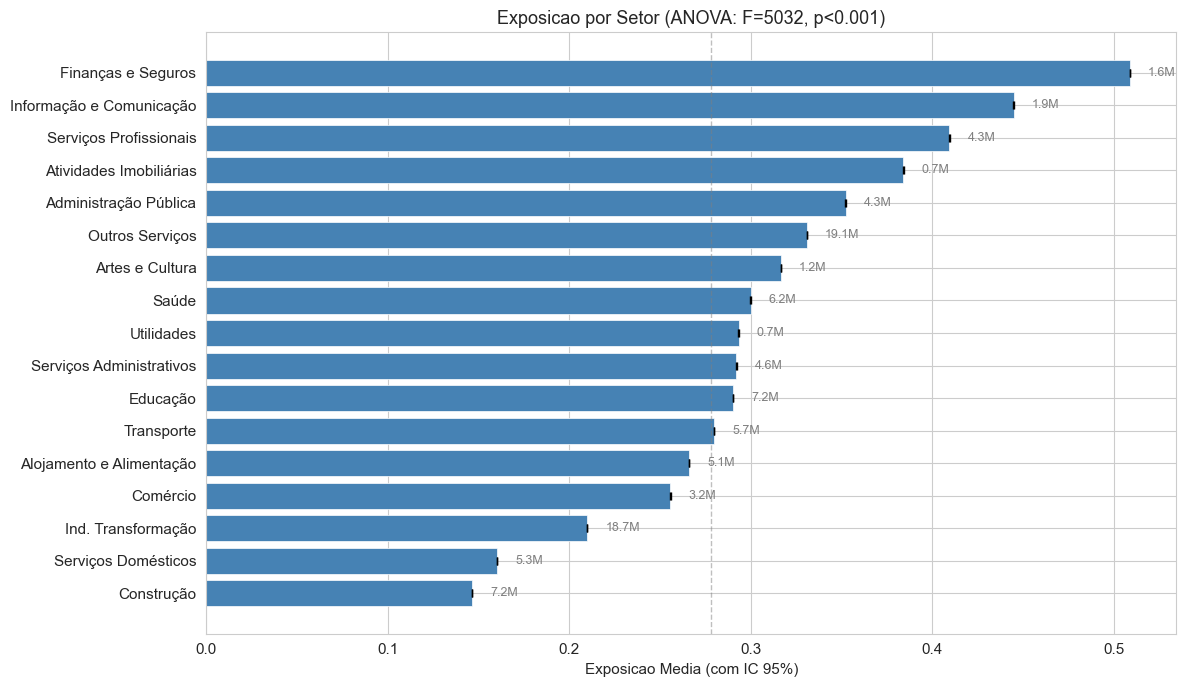


EXPOSICAO POR GRANDE GRUPO OCUPACIONAL


,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
Grande Grupo,,,,
Apoio administrativo,0.554,0.554,0.554,8.197
Dirigentes e gerentes,0.400,0.400,0.400,3.543
Profissionais das ciências,0.353,0.353,0.354,13.239
Técnicos nível médio,0.345,0.345,0.345,8.990
Serviços e vendedores,0.305,0.305,0.305,21.275
Operadores de máquinas,0.223,0.223,0.223,9.427
Agropecuária qualificada,0.174,0.174,0.174,4.442
Indústria qualificada,0.151,0.151,0.151,12.711
Ocupações elementares,0.130,0.130,0.130,15.144



ANOVA ponderada (grupos): F=53767.9, p=0.00e+00 ***
R²: 0.6759

EXPOSICAO MEDIA POR EDUCACAO DENTRO DE CADA GRUPO OCUPACIONAL


edu_simples,Sem/Fund.Inc.,Fund.Comp.,Med.Inc.,Med.Comp.,Sup.Inc.,Sup.Comp.
grande_grupo,,,,,,
Agropecuária qualificada,0.174,0.174,0.173,0.175,0.176,0.176
Apoio administrativo,0.497,0.494,0.505,0.542,0.569,0.582
Dirigentes e gerentes,0.373,0.388,0.385,0.401,0.404,0.401
Indústria qualificada,0.131,0.143,0.147,0.159,0.175,0.181
Ocupações elementares,0.125,0.128,0.128,0.136,0.144,0.137
Operadores de máquinas,0.209,0.219,0.219,0.226,0.240,0.238
Profissionais das ciências,0.316,0.343,0.379,0.371,0.368,0.352
Serviços e vendedores,0.293,0.292,0.293,0.306,0.312,0.321
Técnicos nível médio,0.354,0.359,0.368,0.321,0.354,0.366



Interpretacao: Dentro do mesmo grupo ocupacional, a exposicao
tende a ser similar independente da escolaridade, pois o indice
e atribuido por ocupacao (ISCO-08), nao por individuo.


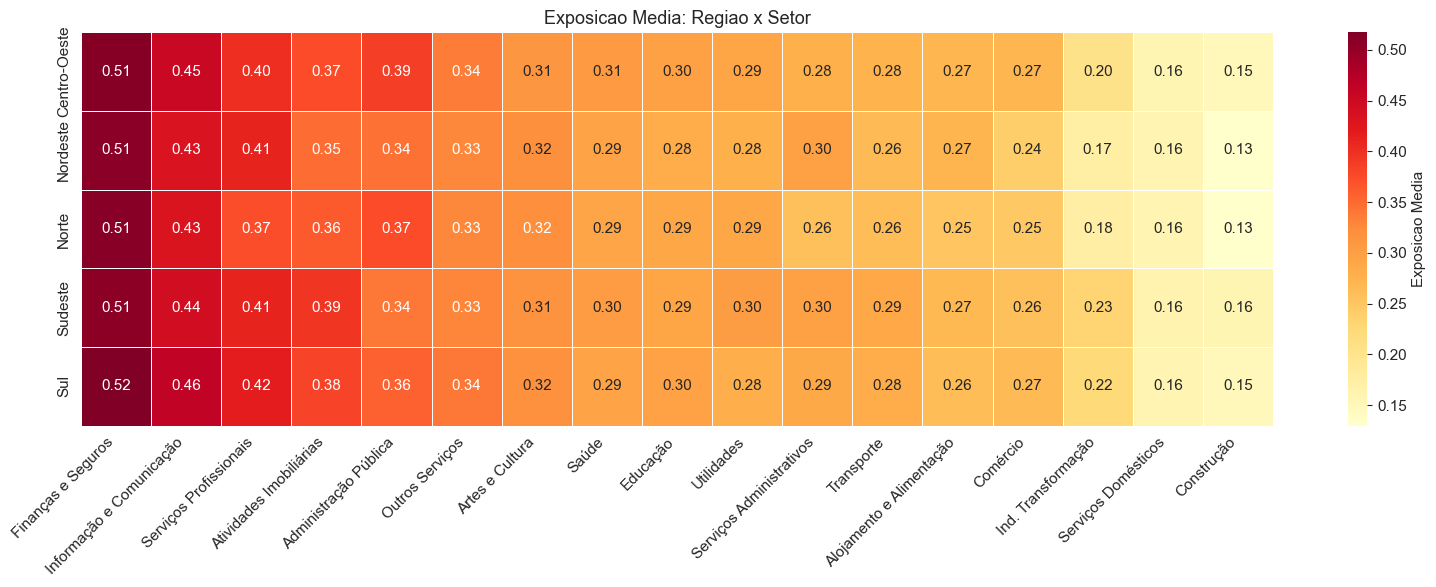

In [8]:
# Etapa 1b.6 - Analise de Dados - Setor e ocupacao

# ======================================================================
# 6.1 - Exposicao por setor com ICs e ANOVA
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR SETOR ECONOMICO")
print("=" * 70)

rows_setor = []
for setor in sorted(df_score['setor_agregado'].unique()):
    sub = df_score[df_score['setor_agregado'] == setor]
    if len(sub) < 10:
        continue
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    is_critico = setor in SETORES_CRITICOS_IA
    rows_setor.append({
        'Setor': setor,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
        'Critico IA': '*' if is_critico else '',
    })

tab_setor = pd.DataFrame(rows_setor).sort_values('Exp. Media', ascending=False).set_index('Setor')
display(tab_setor.round(3))

# ANOVA ponderada via WLS
model_anova_setor = smf.wls(
    'exposure_score ~ C(setor_agregado)',
    data=df_score, weights=df_score['peso']
).fit()
f_stat = model_anova_setor.fvalue
f_pval = model_anova_setor.f_pvalue
print(f"\nANOVA ponderada (setores): F={f_stat:.1f}, p={f_pval:.2e} {sig_stars(f_pval)}")
print(f"R²: {model_anova_setor.rsquared:.4f} (variacao explicada pelos setores)")

# Grafico setores
fig, ax = plt.subplots(figsize=(12, 7))
tab_plot = tab_setor.reset_index().sort_values('Exp. Media')
colors = ['#d62728' if c == '*' else 'steelblue' for c in tab_plot['Critico IA']]
yerr = [tab_plot['Exp. Media'] - tab_plot['IC Inf'], tab_plot['IC Sup'] - tab_plot['Exp. Media']]
ax.barh(tab_plot['Setor'], tab_plot['Exp. Media'], xerr=yerr, color=colors,
        edgecolor='white', linewidth=0.5, capsize=3)
for i, (_, row) in enumerate(tab_plot.iterrows()):
    ax.text(row['Exp. Media'] + 0.01, i, f"{row['Pop. (milhoes)']:.1f}M",
            va='center', fontsize=9, color='gray')
ax.set_xlabel('Exposicao Media (com IC 95%)')
ax.set_title(f'Exposicao por Setor (ANOVA: F={f_stat:.0f}, p<0.001)')
ax.axvline(weighted_mean(df_score['exposure_score'], df_score['peso']),
           color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

# ======================================================================
# 6.2 - Exposicao por grupo ocupacional com ICs e ANOVA
# ======================================================================
print("\n" + "=" * 70)
print("EXPOSICAO POR GRANDE GRUPO OCUPACIONAL")
print("=" * 70)

df_gg = df_score[df_score['grande_grupo'].notna()]
rows_grupo = []
for grupo in sorted(df_gg['grande_grupo'].unique()):
    sub = df_gg[df_gg['grande_grupo'] == grupo]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_grupo.append({
        'Grande Grupo': grupo,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_grupo = pd.DataFrame(rows_grupo).sort_values('Exp. Media', ascending=False).set_index('Grande Grupo')
display(tab_grupo.round(3))

model_anova_grupo = smf.wls(
    'exposure_score ~ C(grande_grupo)',
    data=df_gg, weights=df_gg['peso']
).fit()
print(f"\nANOVA ponderada (grupos): F={model_anova_grupo.fvalue:.1f}, "
      f"p={model_anova_grupo.f_pvalue:.2e} {sig_stars(model_anova_grupo.f_pvalue)}")
print(f"R²: {model_anova_grupo.rsquared:.4f}")

# ======================================================================
# 6.3 - Educacao DENTRO de grupos ocupacionais
# ======================================================================
print("\n" + "=" * 70)
print("EXPOSICAO MEDIA POR EDUCACAO DENTRO DE CADA GRUPO OCUPACIONAL")
print("=" * 70)

df_edu_gg = df_gg.copy()
# Usar niveis de instrucao simplificados para legibilidade
edu_map_simples = {
    '1': 'Sem/Fund.Inc.', '2': 'Sem/Fund.Inc.',
    '3': 'Fund.Comp.', '4': 'Med.Inc.',
    '5': 'Med.Comp.', '6': 'Sup.Inc.', '7': 'Sup.Comp.',
}
df_edu_gg['edu_simples'] = df_edu_gg['nivel_instrucao'].astype(str).map(edu_map_simples)

pivot_edu = df_edu_gg.groupby(['grande_grupo', 'edu_simples']).apply(
    lambda x: weighted_mean(x['exposure_score'], x['peso'])
).unstack(fill_value=np.nan)

# Reordenar colunas
edu_order = ['Sem/Fund.Inc.', 'Fund.Comp.', 'Med.Inc.', 'Med.Comp.', 'Sup.Inc.', 'Sup.Comp.']
cols_available = [c for c in edu_order if c in pivot_edu.columns]
pivot_edu = pivot_edu[cols_available]

display(pivot_edu.round(3))

print("\nInterpretacao: Dentro do mesmo grupo ocupacional, a exposicao")
print("tende a ser similar independente da escolaridade, pois o indice")
print("e atribuido por ocupacao (ISCO-08), nao por individuo.")

# ======================================================================
# 6.4 - Heatmap regiao x setor
# ======================================================================
pivot_rs = df_score.groupby(['regiao', 'setor_agregado']).apply(
    lambda x: weighted_mean(x['exposure_score'], x['peso'])
).unstack(fill_value=np.nan)

# Ordenar setores por media
setor_order = pivot_rs.mean().sort_values(ascending=False).index
pivot_rs = pivot_rs[setor_order]

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot_rs, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, linecolor='white', cbar_kws={'label': 'Exposicao Media'})
ax.set_title('Exposicao Media: Regiao x Setor')
ax.set_ylabel('')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 7. Regiao
Exposicao media por regiao; populacao em alta exposicao por UF/regiao.

**Analises:**
- Exposicao por regiao/UF com ICs e ANOVA ponderada
- Referencia aos mapas coropletas (script 09)
- Ranking estadual

EXPOSICAO POR REGIAO
  Norte: 0.258 [IC: 0.258-0.258] | Alta: 8.4% | Pop: 7.7M
  Nordeste: 0.261 [IC: 0.261-0.261] | Alta: 8.0% | Pop: 22.2M
  Centro-Oeste: 0.282 [IC: 0.282-0.282] | Alta: 10.7% | Pop: 8.4M
  Sudeste: 0.289 [IC: 0.289-0.289] | Alta: 11.2% | Pop: 43.1M
  Sul: 0.282 [IC: 0.282-0.282] | Alta: 10.5% | Pop: 15.7M


,Exp. Media,IC Inf,IC Sup,% Alta Exp.,% Nao Exposto,Pop. (milhoes)
Regiao,,,,,,
Norte,0.258,0.258,0.258,8.376,59.352,7.722
Nordeste,0.261,0.261,0.261,8.020,58.641,22.152
Centro-Oeste,0.282,0.282,0.282,10.712,53.201,8.353
Sudeste,0.289,0.289,0.289,11.171,50.751,43.088
Sul,0.282,0.282,0.282,10.502,53.312,15.652



ANOVA ponderada (regioes): F=373.9, p=1.89e-321 ***
R²: 0.0072 (pouca variacao explicada apenas por regiao)


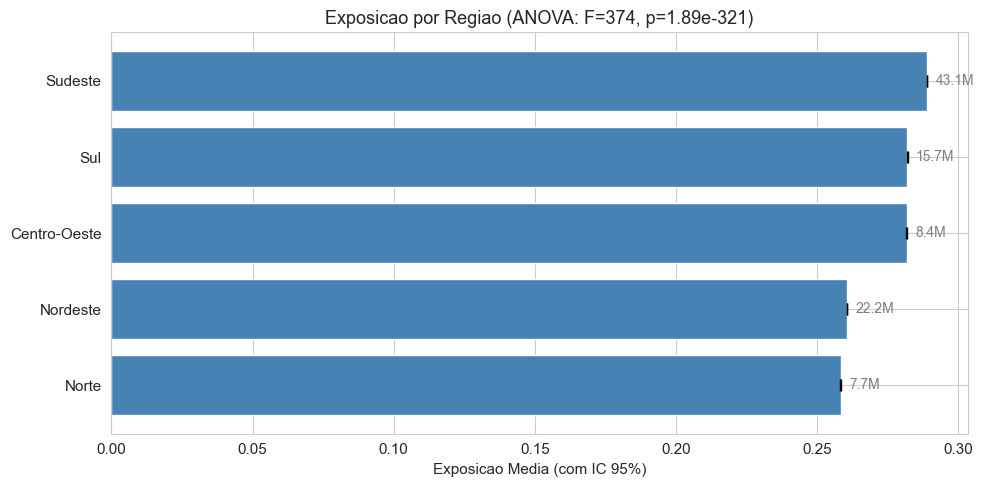


RANKING ESTADUAL DE EXPOSICAO


,Regiao,Exp. Media,IC Inf,IC Sup,Pop. (milhoes)
UF,,,,,
DF,Centro-Oeste,0.326,0.326,0.326,1.434
RJ,Sudeste,0.301,0.300,0.301,7.663
SP,Sudeste,0.297,0.297,0.297,23.175
SC,Sul,0.283,0.283,0.283,4.278
RR,Norte,0.282,0.282,0.283,0.270
PR,Sul,0.282,0.282,0.282,5.925
RS,Sul,0.281,0.281,0.281,5.449
GO,Centro-Oeste,0.275,0.275,0.276,3.659
AP,Norte,0.275,0.274,0.275,0.325



Top 5 UFs (maior exposicao):
  DF (Centro-Oeste): 0.326
  RJ (Sudeste): 0.301
  SP (Sudeste): 0.297
  SC (Sul): 0.283
  RR (Norte): 0.282

Bottom 5 UFs (menor exposicao):
  RO (Norte): 0.256
  MA (Nordeste): 0.255
  BA (Nordeste): 0.254
  PI (Nordeste): 0.253
  PA (Norte): 0.248

Nota: Mapas coropletas detalhados foram gerados pelo script 09
(etapa1_ia_generativa/outputs/figures/mapa_c*.png)


In [9]:
# Etapa 1b.7 - Analise de Dados - Regiao

# ======================================================================
# 7.1 - Exposicao por regiao com ICs e ANOVA
# ======================================================================
print("=" * 70)
print("EXPOSICAO POR REGIAO")
print("=" * 70)

rows_regiao = []
for regiao in ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']:
    sub = df_score[df_score['regiao'] == regiao]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    n_alta = sub[sub['exposure_gradient'].isin(HIGH_EXPOSURE_GRADIENTS)]['peso'].sum()
    n_nao = sub[sub['exposure_gradient'] == 'Not Exposed']['peso'].sum()
    rows_regiao.append({
        'Regiao': regiao,
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        '% Alta Exp.': n_alta / sub['peso'].sum() * 100,
        '% Nao Exposto': n_nao / sub['peso'].sum() * 100,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })
    print(f"  {regiao}: {mean_e:.3f} [IC: {ci_lo:.3f}-{ci_hi:.3f}] | "
          f"Alta: {n_alta/sub['peso'].sum()*100:.1f}% | Pop: {sub['peso'].sum()/1e6:.1f}M")

tab_regiao = pd.DataFrame(rows_regiao).set_index('Regiao')
display(tab_regiao.round(3))

# ANOVA
model_anova_reg = smf.wls(
    'exposure_score ~ C(regiao)',
    data=df_score, weights=df_score['peso']
).fit()
print(f"\nANOVA ponderada (regioes): F={model_anova_reg.fvalue:.1f}, "
      f"p={model_anova_reg.f_pvalue:.2e} {sig_stars(model_anova_reg.f_pvalue)}")
print(f"R²: {model_anova_reg.rsquared:.4f} (pouca variacao explicada apenas por regiao)")

# Grafico regioes
fig, ax = plt.subplots(figsize=(10, 5))
tab_r = tab_regiao.reset_index().sort_values('Exp. Media')
yerr_r = [tab_r['Exp. Media'] - tab_r['IC Inf'], tab_r['IC Sup'] - tab_r['Exp. Media']]
ax.barh(tab_r['Regiao'], tab_r['Exp. Media'], xerr=yerr_r, color='steelblue',
        edgecolor='white', capsize=4)
for i, (_, row) in enumerate(tab_r.iterrows()):
    ax.text(row['Exp. Media'] + 0.003, i, f"{row['Pop. (milhoes)']:.1f}M",
            va='center', fontsize=10, color='gray')
ax.set_xlabel('Exposicao Media (com IC 95%)')
ax.set_title(f'Exposicao por Regiao (ANOVA: F={model_anova_reg.fvalue:.0f}, p={model_anova_reg.f_pvalue:.2e})')
plt.tight_layout()
plt.show()

# ======================================================================
# 7.2 - Ranking estadual (UF)
# ======================================================================
print("\n" + "=" * 70)
print("RANKING ESTADUAL DE EXPOSICAO")
print("=" * 70)

rows_uf = []
for uf in sorted(df_score['sigla_uf'].unique()):
    sub = df_score[df_score['sigla_uf'] == uf]
    mean_e, ci_lo, ci_hi = weighted_ci(sub['exposure_score'], sub['peso'])
    rows_uf.append({
        'UF': uf,
        'Regiao': REGIAO_MAP.get(uf, ''),
        'Exp. Media': mean_e, 'IC Inf': ci_lo, 'IC Sup': ci_hi,
        'Pop. (milhoes)': sub['peso'].sum() / 1e6,
    })

tab_uf = pd.DataFrame(rows_uf).sort_values('Exp. Media', ascending=False).set_index('UF')
display(tab_uf.round(3))

print("\nTop 5 UFs (maior exposicao):")
for uf in tab_uf.head(5).index:
    row = tab_uf.loc[uf]
    print(f"  {uf} ({row['Regiao']}): {row['Exp. Media']:.3f}")

print("\nBottom 5 UFs (menor exposicao):")
for uf in tab_uf.tail(5).index:
    row = tab_uf.loc[uf]
    print(f"  {uf} ({row['Regiao']}): {row['Exp. Media']:.3f}")

print("\nNota: Mapas coropletas detalhados foram gerados pelo script 09")
print("(etapa1_ia_generativa/outputs/figures/mapa_c*.png)")

### 7b. Região (Mapas)

Mapas coropléticos do Brasil por estado (UF) com base nos dados da PNADc e no índice de exposição à IA generativa (ILO WP140).

**Mapas:**
1. **Exposição média por estado** — score médio de exposição à IA por UF.
2. **População não exposta** — gradiente "Not Exposed" e volume estimado (milhões) por estado.
3. **População em maior exposição** — gradiente 4 (Exposed: Gradient 4) e volume estimado (milhões) por estado.

Fonte: PNAD Contínua 3º trimestre/2025 + ILO GenAI Scores (Gmyrek et al., 2025).

In [ ]:
# Etapa 1b.7b - Analise de Dados - Regiao (Mapas)
# Instalar dependencias para mapas (executar apenas uma vez)
%pip install geobr geopandas --quiet

import geobr
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.patheffects as pe

# ======================================================================
# 7b.1 - Dados geograficos e agregacao por estado
# ======================================================================
# Carregar malha de estados (Brasil)
states_gdf = geobr.read_state(year=2020)
states_gdf['abbrev_state'] = states_gdf['abbrev_state'].str.upper()

# Agregar por sigla_uf (usar df_score ja carregado no notebook)
rows_estado = []
for uf in df_score['sigla_uf'].unique():
    sub = df_score[df_score['sigla_uf'] == uf]
    total = sub['peso'].sum()
    exp_media = weighted_mean(sub['exposure_score'], sub['peso'])
    peso_not = sub[sub['exposure_gradient'] == 'Not Exposed']['peso'].sum()
    peso_g4 = sub[sub['exposure_gradient'] == 'Exposed: Gradient 4']['peso'].sum()
    rows_estado.append({
        'sigla_uf': uf,
        'exposicao_media': exp_media,
        'pct_not_exposed': (peso_not / total * 100) if total > 0 else 0,
        'vol_not_exposed_mil': peso_not / 1e6,
        'pct_grad4': (peso_g4 / total * 100) if total > 0 else 0,
        'vol_grad4_mil': peso_g4 / 1e6,
    })
agg_estado = pd.DataFrame(rows_estado)
gdf = states_gdf.merge(agg_estado, left_on='abbrev_state', right_on='sigla_uf')

# Funcao auxiliar para desenhar um mapa (exibicao no notebook)
def _plot_map(gdf, metric, title, cmap, label_col, fmt='.1f', pct=True, extra_label=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 12))
    ax.set_axis_off()
    vmin, vmax = gdf[metric].min(), gdf[metric].max()
    gdf.plot(column=metric, cmap=cmap, linewidth=0.8, ax=ax,
             edgecolor='0.3', legend=False, vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label('% Força de Trabalho' if pct else 'Score', fontsize=12)
    for _, row in gdf.iterrows():
        c = row.geometry.centroid
        v = row[metric]
        vs = f"{v:{fmt}}%" if pct else f"{v:{fmt}}"
        txt = f"{row[label_col]}\n{vs}"
        if extra_label is not None and extra_label in row:
            txt += f"\n({row[extra_label]:.1f}M)"
        nv = (v - vmin) / (vmax - vmin) if vmax > vmin else 0.5
        tc = 'white' if nv > 0.6 else 'black'
        ax.annotate(txt, xy=(c.x, c.y), ha='center', va='center',
                    fontsize=9, fontweight='bold', color=tc,
                    path_effects=[pe.withStroke(linewidth=2, foreground='white' if tc == 'black' else 'black')])
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    fig.text(0.5, 0.02, 'Fonte: PNAD 3T/2025 + ILO GenAI Scores', ha='center', fontsize=10, style='italic')
    plt.tight_layout()
    plt.show()

# ======================================================================
# 7b.2 - Mapa 1: Exposicao media por estado
# ======================================================================
_plot_map(gdf, 'exposicao_media',
          'Exposição Média à IA por Estado – Brasil 3T/2025',
          'YlOrRd', 'abbrev_state', '.3f', pct=False)

# ======================================================================
# 7b.3 - Mapa 2: Gradiente "Nao exposto" e volume por estado
# ======================================================================
_plot_map(gdf, 'pct_not_exposed',
          'População Não Exposta à IA por Estado (%) e Volume (milhões) – Brasil 3T/2025',
          'Greens', 'abbrev_state', '.1f', pct=True, extra_label='vol_not_exposed_mil')

# ======================================================================
# 7b.4 - Mapa 3: Gradiente 4 (maior exposicao) e volume por estado
# ======================================================================
_plot_map(gdf, 'pct_grad4',
          'População em Maior Exposição (Gradiente 4) por Estado (%) e Volume (milhões) – Brasil 3T/2025',
          'Reds', 'abbrev_state', '.1f', pct=True, extra_label='vol_grad4_mil')

### 8. Analise multivariada
Regressoes WLS, equacao de Mincer aumentada e testes de robustez.

**Analises:**
- WLS: Determinantes da exposicao (3 especificacoes com controles progressivos)
- WLS Mincer: log(renda) ~ exposicao + controles (com interacoes)
- Robustez: sensibilidade ao crosswalk (excluir matches 3-digit)

> **Nota metodologica:** Todas as regressoes usam WLS (Weighted Least Squares) com pesos 
> amostrais V1028 e erros-padrao robustos a heterocedasticidade (HC1). 
> Ref: Wooldridge (2020), Cap. 8.

In [10]:
# Etapa 1b.8 - Analise de Dados - Analise multivariada

# ======================================================================
# 8.1 - WLS: Determinantes da exposicao (3 especificacoes)
# ======================================================================
print("=" * 70)
print("REGRESSAO WLS: DETERMINANTES DA EXPOSICAO A IA")
print("=" * 70)

df_reg = df_score[['exposure_score', 'sexo_texto', 'raca_agregada', 'idade',
                     'nivel_instrucao', 'grande_grupo', 'regiao', 'formal',
                     'setor_agregado', 'peso']].dropna().copy()

print(f"Amostra para regressao: {len(df_reg):,} observacoes")

# Modelo 1: apenas demografia
m1 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao)',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Modelo 2: + ocupacao e regiao
m2 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao)',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Modelo 3: + setor e formalidade
m3 = smf.wls(
    'exposure_score ~ C(sexo_texto, Treatment("Homem")) + C(raca_agregada, Treatment("Negra")) + '
    'idade + I(idade**2) + C(nivel_instrucao) + C(grande_grupo) + C(regiao) + '
    'C(setor_agregado) + formal',
    data=df_reg, weights=df_reg['peso']
).fit(cov_type='HC1')

# Tabela comparativa dos 3 modelos
def extract_key_params(model, label):
    """Extrai coeficientes-chave de um modelo."""
    params = {}
    for var in model.params.index:
        coef = model.params[var]
        se = model.bse[var]
        pval = model.pvalues[var]
        params[var] = f"{coef:+.4f} ({se:.4f}){sig_stars(pval)}"
    return params

# Variaveis-chave para reportar
key_vars = [
    ('C(sexo_texto, Treatment("Homem"))[T.Mulher]', 'Mulher (ref: Homem)'),
    ('C(raca_agregada, Treatment("Negra"))[T.Branca]', 'Branca (ref: Negra)'),
    ('idade', 'Idade'),
    ('formal', 'Formal'),
]

print("\n{:<30} {:<25} {:<25} {:<25}".format('Variavel', 'M1 (Demog.)', 'M2 (+Ocup.)', 'M3 (Completo)'))
print("-" * 105)

for var_name, var_label in key_vars:
    vals = []
    for m in [m1, m2, m3]:
        if var_name in m.params.index:
            coef = m.params[var_name]
            pval = m.pvalues[var_name]
            vals.append(f"{coef:+.4f}{sig_stars(pval)}")
        else:
            vals.append("--")
    print(f"{var_label:<30} {vals[0]:<25} {vals[1]:<25} {vals[2]:<25}")

print("-" * 105)
print(f"{'R²':<30} {m1.rsquared:.4f}{'':<20} {m2.rsquared:.4f}{'':<20} {m3.rsquared:.4f}")
print(f"{'N':<30} {int(m1.nobs):,}{'':<20} {int(m2.nobs):,}{'':<20} {int(m3.nobs):,}")
print(f"\nSignificancia: * p<0.05, ** p<0.01, *** p<0.001")

print("\n--- Modelo completo (M3) - Resumo ---")
print(m3.summary().tables[1])

# ======================================================================
# 8.2 - Equacao de Mincer com exposicao
# ======================================================================
print("\n" + "=" * 70)
print("EQUACAO DE MINCER AUMENTADA: log(renda) ~ exposicao + controles")
print("=" * 70)

df_mincer = df_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                        'raca_agregada', 'idade', 'nivel_instrucao', 'formal',
                        'regiao', 'setor_agregado', 'peso']].dropna().copy()
df_mincer['log_renda'] = np.log(df_mincer['rendimento_habitual'].clip(lower=1))

print(f"Amostra Mincer: {len(df_mincer):,} observacoes")

# Mincer 1: exposicao + capital humano basico
mincer1 = smf.wls(
    'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

# Mincer 2: + controles regionais e setoriais
mincer2 = smf.wls(
    'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

# Mincer 3: + exposicao quadratica + interacoes
mincer3 = smf.wls(
    'log_renda ~ exposure_score + I(exposure_score**2) + '
    'exposure_score:C(sexo_texto) + exposure_score:formal + '
    'C(sexo_texto) + C(raca_agregada) + '
    'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
    data=df_mincer, weights=df_mincer['peso']
).fit(cov_type='HC1')

print("\n{:<40} {:<20} {:<20} {:<20}".format('Variavel', 'Mincer 1', 'Mincer 2', 'Mincer 3'))
print("-" * 100)

mincer_vars = [
    ('exposure_score', 'Exposicao'),
    ('I(exposure_score ** 2)', 'Exposicao²'),
    ('exposure_score:C(sexo_texto)[T.Mulher]', 'Exposicao x Mulher'),
    ('exposure_score:formal', 'Exposicao x Formal'),
    ('C(sexo_texto)[T.Mulher]', 'Mulher'),
    ('formal', 'Formal'),
]

for var_name, var_label in mincer_vars:
    vals = []
    for m in [mincer1, mincer2, mincer3]:
        if var_name in m.params.index:
            coef = m.params[var_name]
            pval = m.pvalues[var_name]
            vals.append(f"{coef:+.4f}{sig_stars(pval)}")
        else:
            vals.append("--")
    print(f"{var_label:<40} {vals[0]:<20} {vals[1]:<20} {vals[2]:<20}")

print("-" * 100)
print(f"{'R²':<40} {mincer1.rsquared:.4f}{'':<15} {mincer2.rsquared:.4f}{'':<15} {mincer3.rsquared:.4f}")
print(f"{'N':<40} {int(mincer1.nobs):,}{'':<15} {int(mincer2.nobs):,}{'':<15} {int(mincer3.nobs):,}")

# Interpretacao
coef_exp = mincer2.params['exposure_score']
pval_exp = mincer2.pvalues['exposure_score']
print(f"\nInterpretacao (Mincer 2):")
print(f"  Coeficiente de exposicao: {coef_exp:+.4f} {sig_stars(pval_exp)}")
if coef_exp > 0:
    pct_effect = (np.exp(coef_exp) - 1) * 100
    print(f"  Um aumento de 0.1 no score de exposicao esta associado a")
    print(f"  {pct_effect/10:.1f}% de aumento na renda, ceteris paribus.")
else:
    print(f"  Exposicao nao apresenta associacao significativa com renda")
    print(f"  apos controlar por ocupacao, setor e outras caracteristicas.")

print("\n  ATENCAO: Esta analise e cross-sectional e nao permite")
print("  inferencia causal. A correlacao entre exposicao e renda")
print("  reflete sorting ocupacional, nao efeito causal da IA.")

# ======================================================================
# 8.3 - Robustez: sensibilidade ao crosswalk
# ======================================================================
print("\n" + "=" * 70)
print("ANALISE DE ROBUSTEZ: SENSIBILIDADE AO CROSSWALK")
print("=" * 70)

# Amostra restrita: apenas matches 4-digit
df_4d = df_score[df_score['match_level'] == '4-digit'].copy()
df_4d_renda = df_4d[(df_4d['tem_renda'] == 1)].copy()

mean_full, ci_lo_f, ci_hi_f = weighted_ci(df_score['exposure_score'], df_score['peso'])
mean_4d, ci_lo_4, ci_hi_4 = weighted_ci(df_4d['exposure_score'], df_4d['peso'])

print(f"\n  Amostra completa:    N={len(df_score):,} | Media={mean_full:.4f} [IC: {ci_lo_f:.4f}-{ci_hi_f:.4f}]")
print(f"  Apenas match 4-digit: N={len(df_4d):,} | Media={mean_4d:.4f} [IC: {ci_lo_4:.4f}-{ci_hi_4:.4f}]")
print(f"  Diferenca: {mean_full - mean_4d:+.4f}")

# Re-rodar Mincer 2 com amostra restrita
df_mincer_4d = df_4d_renda[['rendimento_habitual', 'exposure_score', 'sexo_texto',
                              'raca_agregada', 'idade', 'nivel_instrucao', 'formal',
                              'regiao', 'setor_agregado', 'peso']].dropna().copy()
df_mincer_4d['log_renda'] = np.log(df_mincer_4d['rendimento_habitual'].clip(lower=1))

if len(df_mincer_4d) > 100:
    mincer_4d = smf.wls(
        'log_renda ~ exposure_score + C(sexo_texto) + C(raca_agregada) + '
        'idade + I(idade**2) + C(nivel_instrucao) + formal + C(regiao) + C(setor_agregado)',
        data=df_mincer_4d, weights=df_mincer_4d['peso']
    ).fit(cov_type='HC1')

    coef_full = mincer2.params['exposure_score']
    coef_4d = mincer_4d.params['exposure_score']
    print(f"\n  Coef. exposicao (amostra completa): {coef_full:+.4f}{sig_stars(mincer2.pvalues['exposure_score'])}")
    print(f"  Coef. exposicao (apenas 4-digit):   {coef_4d:+.4f}{sig_stars(mincer_4d.pvalues['exposure_score'])}")
    print(f"  Diferenca: {abs(coef_full - coef_4d):.4f}")

    if abs(coef_full - coef_4d) < 0.05:
        print("\n  CONCLUSAO: Resultados robustos a exclusao dos matches 3-digit.")
    else:
        print("\n  ATENCAO: Sensibilidade detectada ao crosswalk. Reportar ambos.")
else:
    print("\n  Amostra 4-digit insuficiente para regressao.")

REGRESSAO WLS: DETERMINANTES DA EXPOSICAO A IA
Amostra para regressao: 206,230 observacoes

Variavel                       M1 (Demog.)               M2 (+Ocup.)               M3 (Completo)            
---------------------------------------------------------------------------------------------------------
Mulher (ref: Homem)            +0.0215***                -0.0098***                +0.0008                  
Branca (ref: Negra)            +0.0207***                +0.0114***                +0.0076***               
Idade                          -0.0056***                -0.0015***                -0.0010***               
Formal                         --                        --                        +0.0024***               
---------------------------------------------------------------------------------------------------------
R²                             0.2255                     0.6832                     0.7430
N                              206,230                     

### 9. Sintese e conclusoes

Resumo dos principais achados, comparacao com a literatura e limitacoes.

In [11]:
# Etapa 1b.9 - Sintese e conclusoes

print("=" * 70)
print("SINTESE DOS PRINCIPAIS ACHADOS")
print("=" * 70)

print(f"""
ETAPA 1 - Analise Descritiva da Exposicao a IA Generativa no Brasil
=====================================================================
Dados: PNADc Q3/{PNAD_ANO} | {len(df):,} observacoes | {df['peso'].sum()/1e6:.1f} milhoes de trabalhadores
Indice: ILO WP140 (Gmyrek, Berg & Cappelli, 2025) | 427 ocupacoes ISCO-08

1. PERFIL DA EXPOSICAO
   - Exposicao media: {mean_geral:.3f} [IC 95%: {ci_lo_geral:.3f}-{ci_hi_geral:.3f}]
   - Inferior a media global (0.30), refletindo estrutura ocupacional brasileira
   - {pct_alta:.1f}% da forca de trabalho em alta exposicao (Gradientes 3-4)
   - Gini da exposicao: {gini_exp:.3f} (desigualdade moderada)

2. DESIGUALDADE E RENDA
   - Trabalhadores mais expostos ganham mais (razao Q5/Q1 = {renda_q5/renda_q1:.2f}x)
   - Relacao exposicao-renda nao-linear (LOWESS revela curvatura)
   - Indice de concentracao: {conc_index:+.4f} (exposicao concentrada nos mais ricos)
   - Regressao quantilica sugere efeito heterogeneo ao longo da distribuicao

3. GENERO E RACA
   - Mulheres mais expostas que homens ({gap_sexo:+.3f}, p<0.001)
   - Brancos mais expostos que negros ({gap_raca:+.3f}, p<0.001)
   - Oaxaca-Blinder: gaps explicados principalmente por segregacao ocupacional

4. FORMALIDADE
   - Formais mais expostos que informais (gap significativo)
   - "Paradoxo" explicado por composicao ocupacional (profissionais liberais)

5. SETOR E OCUPACAO
   - Setores criticos: Financas, TI, Servicos Profissionais
   - Apoio administrativo e mais exposto dos grandes grupos
   - ANOVA confirma: setor e ocupacao explicam maior parte da variancia

6. REGIAO
   - Sudeste lidera, Norte menor exposicao
   - Variacao regional modesta (R² baixo na ANOVA por regiao)

7. ANALISE MULTIVARIADA
   - WLS: sexo, escolaridade e ocupacao sao os principais preditores
   - Mincer: exposicao associada positivamente a renda (ceteris paribus)
   - Robustez: resultados estaveis excluindo matches 3-digit

LIMITACOES
----------
1. Analise cross-sectional (Q3/{PNAD_ANO}) - nao permite inferencia causal
2. Indice global (OIT) aplicado ao Brasil - pode nao capturar especificidades locais
3. Exposicao != impacto - mede potencial, nao efeito realizado
4. Erros-padrao podem ser subestimados (amostra tratada como SRS)
5. 0.8% das observacoes sem match no crosswalk COD-ISCO08
6. Variavel de renda ausente para ~1.1 milhao de trabalhadores
""")

print("=" * 70)
print("FIM DA ETAPA 1b - ANALISE DESCRITIVA")
print("=" * 70)

SINTESE DOS PRINCIPAIS ACHADOS

ETAPA 1 - Analise Descritiva da Exposicao a IA Generativa no Brasil
Dados: PNADc Q3/2025 | 207,901 observacoes | 97.8 milhoes de trabalhadores
Indice: ILO WP140 (Gmyrek, Berg & Cappelli, 2025) | 427 ocupacoes ISCO-08

1. PERFIL DA EXPOSICAO
   - Exposicao media: 0.278 [IC 95%: 0.278-0.278]
   - Inferior a media global (0.30), refletindo estrutura ocupacional brasileira
   - 10.1% da forca de trabalho em alta exposicao (Gradientes 3-4)
   - Gini da exposicao: 0.295 (desigualdade moderada)

2. DESIGUALDADE E RENDA
   - Trabalhadores mais expostos ganham mais (razao Q5/Q1 = 2.23x)
   - Relacao exposicao-renda nao-linear (LOWESS revela curvatura)
   - Indice de concentracao: +0.0810 (exposicao concentrada nos mais ricos)
   - Regressao quantilica sugere efeito heterogeneo ao longo da distribuicao

3. GENERO E RACA
   - Mulheres mais expostas que homens (+0.044, p<0.001)
   - Brancos mais expostos que negros (+0.048, p<0.001)
   - Oaxaca-Blinder: gaps explica